## **Evolution beats random chance: Performance-dependent networ evolution for enhanced computational capacity.<br> M. Yadav, S. Sinha and M. Stender. arXiv**: https://arxiv.org/abs/2403.15869

## -> Following figures can be plotted from this notebook: <br>  Fig.3 (b), (c), (e), (f), (h) and (i), Fig.4 and Fig. 6


## -> Plotting figures from data of following net. models: 
- Erdos Renyi Random Nets. -> **N0**
- Pefomormance Independent. Net. growth -> **N1**
- Pefomormance Dep. Net. growth -> **N2**
- Pefomormance Dep. Net. Evo (PDNE) -> **N3**
 

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import subplot
from matplotlib.ticker import ScalarFormatter

import networkx as nx
import time
from tqdm.notebook import tqdm, trange
import os
import pandas as pd
import seaborn as sns
from numba import jit, cuda
from matplotlib.ticker import FormatStrFormatter
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from matplotlib import ticker as mticker
import matplotlib.animation as animation

In [2]:
def Last_NR_Finder(NR):
    NRs=[]
    for i in range(len(NR)):
        j=-1
        while True:
            if np.isfinite(np.asarray(NR[i]).T[1][j])==True:
                NRs.append(np.asarray(NR[i]).T[1][j])
                break
            else:
                j=j-1
    return np.asarray(NRs)

def LoadData(SaveDir, Task, P_inp, P_out, ModelRep):
    NetMsrs_tst=np.load(os.path.join(SaveDir,'NARMA{:}_NetMeasures_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.npy'.format(Task,\
                                P_inp, P_out, 0))) 
    NetMsrs_Reps=[]; Scores_Reps=[]; Graphs_Reps=[]
    InpsNodes_Reps=[]; OutsNodes_Reps=[]
    for r in range(ModelRep):
        NetMsrs_Reps.append(np.load(os.path.join(SaveDir,'NARMA{:}_NetMeasures_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.npy'\
                                               .format(Task, P_inp, P_out, r))) )
        Scores_Reps.append(np.load(os.path.join(SaveDir,'NARMA{:}_Scores_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.npy'\
                                               .format(Task, P_inp, P_out, r))) ) 
        Graphs_Reps.append(nx.read_gpickle(os.path.join(SaveDir,'NARMA{:}_Graphs_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.gpickle'\
                                               .format(Task, P_inp, P_out, r))) ) 
        InpsNodes_Reps.append(nx.read_gpickle(os.path.join(SaveDir,'NARMA{:}_InpsNodes_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.gpickle'\
                                               .format(Task, P_inp, P_out, r))) ) 
        OutsNodes_Reps.append(nx.read_gpickle(os.path.join(SaveDir,'NARMA{:}_OutsNodes_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.gpickle'\
                                               .format(Task, P_inp, P_out, r))) ) 
    NetMsrs_Names = np.load(os.path.join(SaveDir,'NetMeasures_Names.npy'))
    return np.asarray(NetMsrs_Reps), NetMsrs_Names, np.asarray(Scores_Reps), Graphs_Reps, InpsNodes_Reps, OutsNodes_Reps

def LoadData_ER(SaveDir, Task, P_inp, P_out, ModelRep):
    NetMsrs_Reps=np.load(os.path.join(SaveDir,'NARMA{:}_NetMeasures_Pinp{:.2f}_Pout{:.2f}_Reps{:d}.npy'\
                                           .format(Task, P_inp, P_out, ModelRep))) 
    Scores_Reps=np.load(os.path.join(SaveDir,'NARMA{:}_Scores_Pinp{:.2f}_Pout{:.2f}_Reps{:d}.npy'\
                                           .format(Task, P_inp, P_out, ModelRep)))  
    NetMsrs_Names = np.load(os.path.join(SaveDir,'NetMeasures_Names.npy'))
    if Task[0]==10 or Task[0]==15:
        Graphs_Reps=nx.read_gpickle(os.path.join(SaveDir,'ER_Graphs_N10_N15_Pinp{:.2f}_Pout{:.2f}_Reps{:d}.gpickle'\
                                           .format(P_inp, P_out, ModelRep)))  
        InpsNodes_Reps=nx.read_gpickle(os.path.join(SaveDir,'ER_InpsNodes_N10_N15_Pinp{:.2f}_Pout{:.2f}_Reps{:d}.gpickle'\
                                               .format(P_inp, P_out, ModelRep)))  
        OutsNodes_Reps=nx.read_gpickle(os.path.join(SaveDir,'ER_OutsNodes_N10_N15_Pinp{:.2f}_Pout{:.2f}_Reps{:d}.gpickle'\
                                               .format(P_inp, P_out, ModelRep)))  
    if Task[0]==5:
        Graphs_Reps=nx.read_gpickle(os.path.join(SaveDir,'ER_Graphs_N5_Pinp{:.2f}_Pout{:.2f}_Reps{:d}.gpickle'\
                                           .format(P_inp, P_out, ModelRep)))  
        InpsNodes_Reps=nx.read_gpickle(os.path.join(SaveDir,'ER_InpsNodes_N5_Pinp{:.2f}_Pout{:.2f}_Reps{:d}.gpickle'\
                                               .format(P_inp, P_out, ModelRep)))  
        OutsNodes_Reps=nx.read_gpickle(os.path.join(SaveDir,'ER_OutsNodes_N5_Pinp{:.2f}_Pout{:.2f}_Reps{:d}.gpickle'\
                                               .format(P_inp, P_out, ModelRep)))  
    
    return NetMsrs_Reps, NetMsrs_Names, Scores_Reps, Graphs_Reps, InpsNodes_Reps, OutsNodes_Reps

def LoadData_ER_SCV(SaveDir, Task, InpProps, P_inp, P_out, ModelRep):
    Graphs_Reps=nx.read_gpickle(os.path.join(SaveDir,'ER_Graphs_{:}_Pinp{:.2f}_Pout{:.2f}_Reps{:d}.gpickle'\
                                           .format(Task, P_inp, P_out, ModelRep)))  
    InpsNodes_Reps=nx.read_gpickle(os.path.join(SaveDir,'ER_InpsNodes_{:}_Pinp{:.2f}_Pout{:.2f}_Reps{:d}.gpickle'\
                                           .format(Task, P_inp, P_out, ModelRep)))  
    OutsNodes_Reps=nx.read_gpickle(os.path.join(SaveDir,'ER_OutsNodes_{:}_Pinp{:.2f}_Pout{:.2f}_Reps{:d}.gpickle'\
                                           .format(Task, P_inp, P_out, ModelRep)))
    NetMsrs_Names = np.load(os.path.join(SaveDir,'NetMeasures_Names.npy'))
    if Task=='SinCos':
        NetMsrs_Reps=np.load(os.path.join(SaveDir,'SinCos{:}_NetMeasures_Pinp{:.2f}_Pout{:.2f}_Reps{:d}.npy'\
                                           .format(InpProps[3], P_inp, P_out, ModelRep))) 
        Scores_Reps=np.load(os.path.join(SaveDir,'SinCos{:}_Scores_Pinp{:.2f}_Pout{:.2f}_Reps{:d}.npy'\
                                           .format(InpProps[3], P_inp, P_out, ModelRep)))  
    if Task=='VDP' or Task=='Chaos':
        NetMsrs_Reps=np.load(os.path.join(SaveDir,'{:}_NetMeasures_Pinp{:.2f}_Pout{:.2f}_Reps{:d}.npy'\
                                           .format(Task, P_inp, P_out, ModelRep))) 
        Scores_Reps=np.load(os.path.join(SaveDir,'{:}_Scores_Pinp{:.2f}_Pout{:.2f}_Reps{:d}.npy'\
                                           .format(Task, P_inp, P_out, ModelRep)))      
    return NetMsrs_Reps, NetMsrs_Names, Scores_Reps, Graphs_Reps, InpsNodes_Reps, OutsNodes_Reps

def LoadData_SinCos(SaveDir, Pars, P_inp, P_out, ModelRep):
    NetMsrs_tst=np.load(os.path.join(SaveDir,'SinCos_NodeDel{:d}_a{:}_b{:}_p{:}_NetMeasures_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.npy'.format(Pars[0],\
                                Pars[1], Pars[2], Pars[3], P_inp, P_out, 0))) 
    NetMsrs_Reps=[]; Scores_Reps=[]; Graphs_Reps=[]
    InpsNodes_Reps=[]; OutsNodes_Reps=[]
    for r in range(ModelRep):
        NetMsrs_Reps.append(np.load(os.path.join(SaveDir,'SinCos_NodeDel{:d}_a{:}_b{:}_p{:}_NetMeasures_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.npy'\
                                               .format(Pars[0], Pars[1], Pars[2], Pars[3], P_inp, P_out, r))) )
        Scores_Reps.append(np.load(os.path.join(SaveDir,'SinCos_NodeDel{:d}_a{:}_b{:}_p{:}_Scores_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.npy'\
                                               .format(Pars[0], Pars[1], Pars[2], Pars[3], P_inp, P_out, r))) ) 
        Graphs_Reps.append(nx.read_gpickle(os.path.join(SaveDir,'SinCos_NodeDel{:d}_a{:}_b{:}_p{:}_Graphs_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.gpickle'\
                                               .format(Pars[0], Pars[1], Pars[2], Pars[3], P_inp, P_out, r))) ) 
        InpsNodes_Reps.append(nx.read_gpickle(os.path.join(SaveDir,'SinCos_NodeDel{:d}_a{:}_b{:}_p{:}_InpsNodes_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.gpickle'\
                                               .format(Pars[0], Pars[1], Pars[2], Pars[3], P_inp, P_out, r))) ) 
        OutsNodes_Reps.append(nx.read_gpickle(os.path.join(SaveDir,'SinCos_NodeDel{:d}_a{:}_b{:}_p{:}_OutsNodes_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.gpickle'\
                                               .format(Pars[0], Pars[1], Pars[2], Pars[3], P_inp, P_out, r))) ) 
    NetMsrs_Names = np.load(os.path.join(SaveDir,'NetMeasures_Names.npy'))
    return np.asarray(NetMsrs_Reps), NetMsrs_Names, np.asarray(Scores_Reps), Graphs_Reps, InpsNodes_Reps, OutsNodes_Reps

def LoadData_ChaosVP(SaveDir, TaskType, P_inp, P_out, ModelRep):
    NetMsrs_tst=np.load(os.path.join(SaveDir,'{:}_NetMeasures_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.npy'.format(TaskType,\
                                P_inp, P_out, 0))) 
    NetMsrs_Reps=[]; Scores_Reps=[]; Graphs_Reps=[]
    InpsNodes_Reps=[]; OutsNodes_Reps=[]
    for r in range(ModelRep):
        NetMsrs_Reps.append(np.load(os.path.join(SaveDir,'{:}_NetMeasures_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.npy'\
                                               .format(TaskType, P_inp, P_out, r))) )
        Scores_Reps.append(np.load(os.path.join(SaveDir,'{:}_Scores_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.npy'\
                                               .format(TaskType, P_inp, P_out, r))) ) 
        Graphs_Reps.append(nx.read_gpickle(os.path.join(SaveDir,'{:}_Graphs_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.gpickle'\
                                               .format(TaskType, P_inp, P_out, r))) ) 
        InpsNodes_Reps.append(nx.read_gpickle(os.path.join(SaveDir,'{:}_InpsNodes_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.gpickle'\
                                               .format(TaskType, P_inp, P_out, r))) ) 
        OutsNodes_Reps.append(nx.read_gpickle(os.path.join(SaveDir,'{:}_OutsNodes_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.gpickle'\
                                               .format(TaskType, P_inp, P_out, r))) ) 
    NetMsrs_Names = np.load(os.path.join(SaveDir,'NetMeasures_Names.npy'))
    return np.asarray(NetMsrs_Reps), NetMsrs_Names, np.asarray(Scores_Reps), Graphs_Reps, InpsNodes_Reps, OutsNodes_Reps

def LoadLE_ChaosVP(SaveD, TaskType, P_inp, P_out):
    return np.load(os.path.join(SaveD,'{}_MAE_LE_Pinp{:.2f}_Pout{:.2f}.npy').format(TaskType, P_inp, P_out))

def FirstZeroLocFinder(NetMsrs):
    ZerosLoc = np.where(NetMsrs==0)[0]
    if len(ZerosLoc)>=1:
        ZerosLocFirst=ZerosLoc[0]
    else:
        ZerosLocFirst=-1
    return ZerosLocFirst
            


In [3]:
P_inp=0.5; P_out=0.5
Model_Reps=10

#############Model M3 NARMA#############################################################
SaveDir3 = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/1.NetGrowth_Models/Data/Checkpoint-Model_V3/1Task/N3/NARMA/'
NetMsrsN3_NARMA5_Reps, NetMsrsV3_Names, ScoresN3_NARMA5_Reps, GraphsN3_NARMA5_Reps, InpsNodesN3_NARMA5_Reps,\
OutsNodesN3_NARMA5_Reps = LoadData(SaveDir3, [5], P_inp, P_out, Model_Reps)

NetMsrsN3_NARMA10_Reps, NetMsrsV3_Names, ScoresN3_NARMA10_Reps, GraphsN3_NARMA10_Reps, InpsNodesN3_NARMA10_Reps,\
OutsNodesN3_NARMA10_Reps = LoadData(SaveDir3, [10], P_inp, P_out, Model_Reps)

NetMsrsN3_NARMA15_Reps, NetMsrsV3_Names, ScoresN3_NARMA15_Reps, GraphsN3_NARMA15_Reps, InpsNodesN3_NARMA15_Reps,\
OutsNodesN3_NARMA15_Reps = LoadData(SaveDir3, [15], P_inp, P_out, Model_Reps)

print(NetMsrsN3_NARMA10_Reps.shape, NetMsrsV3_Names, '\n', ScoresN3_NARMA10_Reps.shape,\
      len(InpsNodesN3_NARMA10_Reps[1]), len(GraphsN3_NARMA10_Reps[1]))

#############Model M0 NARMA#############################################################
SaveDir30 = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/1.NetGrowth_Models/Data/Checkpoint-Model_V3/1Task/ERNets/NARMA/'
Model_Reps=500

NetMsrsN0_NARMA5_Reps, NetMsrsV3_Names, ScoresN0_NARMA5_Reps, GraphsN0_NARMA5_Reps, InpsNodesN0_NARMA5_Reps,\
OutsNodesN0_NARMA5_Reps = LoadData_ER(SaveDir30, [5], P_inp, P_out, Model_Reps)

NetMsrsN0_NARMA10_Reps, NetMsrsV3_Names, ScoresN0_NARMA10_Reps, GraphsN0_NARMA10_Reps, InpsNodesN0_NARMA10_Reps,\
OutsNodesN0_NARMA10_Reps = LoadData_ER(SaveDir30, [10], P_inp, P_out, Model_Reps)

NetMsrsN0_NARMA15_Reps, NetMsrsV3_Names, ScoresN0_NARMA15_Reps, GraphsN0_NARMA15_Reps, InpsNodesN0_NARMA15_Reps,\
OutsNodesN0_NARMA15_Reps = LoadData_ER(SaveDir30, [15], P_inp, P_out, Model_Reps)

print(NetMsrsN3_NARMA10_Reps.shape, NetMsrsV3_Names, '\n', ScoresN3_NARMA10_Reps.shape,\
      len(InpsNodesN3_NARMA10_Reps[1]), len(GraphsN3_NARMA10_Reps[1]))

#############Model M1 NARMA#############################################################
SaveDir31 = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/1.NetGrowth_Models/Data/Checkpoint-Model_V3/1Task/N1/NARMA/'
Model_Reps=10
NetMsrsN1_NARMA5_Reps, NetMsrsV3_Names, ScoresN1_NARMA5_Reps, GraphsN1_NARMA5_Reps, InpsNodesN1_NARMA5_Reps,\
OutsNodesN1_NARMA5_Reps = LoadData(SaveDir31, [5], P_inp, P_out, Model_Reps)

NetMsrsN1_NARMA10_Reps, NetMsrsV3_Names, ScoresN1_NARMA10_Reps, GraphsN1_NARMA10_Reps, InpsNodesN1_NARMA10_Reps,\
OutsNodesN1_NARMA10_Reps = LoadData(SaveDir31, [10], P_inp, P_out, Model_Reps)

NetMsrsN1_NARMA15_Reps, NetMsrsV3_Names, ScoresN1_NARMA15_Reps, GraphsN1_NARMA15_Reps, InpsNodesN1_NARMA15_Reps,\
OutsNodesN1_NARMA15_Reps = LoadData(SaveDir31, [15], P_inp, P_out, Model_Reps)

print(NetMsrsN1_NARMA15_Reps.shape, NetMsrsV3_Names, '\n', ScoresN1_NARMA15_Reps.shape,\
      len(InpsNodesN1_NARMA15_Reps[1]), len(GraphsN3_NARMA15_Reps[1]))

#############Model M2 NARMA#############################################################
SaveDir32 = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/1.NetGrowth_Models/Data/Checkpoint-Model_V3/1Task/N2/NARMA/'
NetMsrsN2_NARMA5_Reps, NetMsrsV3_Names, ScoresN2_NARMA5_Reps, GraphsN2_NARMA5_Reps, InpsNodesN2_NARMA5_Reps,\
OutsNodesN2_NARMA5_Reps = LoadData(SaveDir32, [5], P_inp, P_out, Model_Reps)

NetMsrsN2_NARMA10_Reps, NetMsrsV3_Names, ScoresN2_NARMA10_Reps, GraphsN2_NARMA10_Reps, InpsNodesN2_NARMA10_Reps,\
OutsNodesN2_NARMA10_Reps = LoadData(SaveDir32, [10], P_inp, P_out, Model_Reps)

NetMsrsN2_NARMA15_Reps, NetMsrsV3_Names, ScoresN2_NARMA15_Reps, GraphsN2_NARMA15_Reps, InpsNodesN2_NARMA15_Reps,\
OutsNodesN2_NARMA15_Reps = LoadData(SaveDir32, [15], P_inp, P_out, Model_Reps)

print(NetMsrsN2_NARMA10_Reps.shape, NetMsrsV3_Names, '\n', ScoresN2_NARMA15_Reps.shape,\
      len(InpsNodesN2_NARMA15_Reps[1]), len(GraphsN2_NARMA10_Reps[1]))

#############Model M3 SinCos#############################################################
SaveDir4 = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/1.NetGrowth_Models/Data/Checkpoint-Model_V3/1Task/N3/SinCos/'
SaveDir40 = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/1.NetGrowth_Models/Data/Checkpoint-Model_V3/1Task/ERNets/SinCos/'
SaveDir41 = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/1.NetGrowth_Models/Data/Checkpoint-Model_V3/1Task/N1/SinCos/'
SaveDir42 = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/1.NetGrowth_Models/Data/Checkpoint-Model_V3/1Task/N2/SinCos/'
SaveDir4E = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/1.NetGrowth_Models/Data/Checkpoint-Model_V3/1Task/N3/SinCos/ER_Init/'
Model_Reps=10
Pars1=[50, [0], [1], [1]]
Pars2=[50, [1], [0.25], [3]]

NetMsrsN3_SinCos1_Reps, NetMsrsV3_Names, ScoresN3_SinCos1_Reps, GraphsN3_SinCos1_Reps, InpsNodesN3_SinCos1_Reps,\
OutsNodesN3_SinCos1_Reps = LoadData_SinCos(SaveDir4, Pars1, P_inp, P_out, Model_Reps)

NetMsrsN1_SinCos1_Reps, NetMsrsV3_Names, ScoresN1_SinCos1_Reps, GraphsN1_SinCos1_Reps, InpsNodesN1_SinCos1_Reps,\
OutsNodesN1_SinCos1_Reps = LoadData_SinCos(SaveDir41, Pars1, P_inp, P_out, Model_Reps)
NetMsrsN2_SinCos1_Reps, NetMsrsV3_Names, ScoresN2_SinCos1_Reps, GraphsN2_SinCos1_Reps, InpsNodesN2_SinCos1_Reps,\
OutsNodesN2_SinCos1_Reps = LoadData_SinCos(SaveDir42, Pars1, P_inp, P_out, Model_Reps)

Model_Reps=500
NetMsrsN0_SinCos1_Reps, NetMsrsV3_Names, ScoresN0_SinCos1_Reps, GraphsN0_SinCos1_Reps, InpsNodesN0_SinCos1_Reps,\
OutsNodesN0_SinCos1_Reps = LoadData_ER_SCV(SaveDir40, 'SinCos', Pars1, P_inp, P_out, Model_Reps)
NetMsrsN0_SinCos2_Reps, NetMsrsV3_Names, ScoresN0_SinCos2_Reps, GraphsN0_SinCos2_Reps, InpsNodesN0_SinCos2_Reps,\
OutsNodesN0_SinCos2_Reps = LoadData_ER_SCV(SaveDir40, 'SinCos', Pars2, P_inp, P_out, Model_Reps)

Model_Reps=10

NetMsrsN3_SinCos2_Reps, NetMsrsV3_Names, ScoresN3_SinCos2_Reps, GraphsN3_SinCos2_Reps, InpsNodesN3_SinCos2_Reps,\
OutsNodesN3_SinCos2_Reps = LoadData_SinCos(SaveDir4, Pars2, P_inp, P_out, Model_Reps)

NetMsrsN1_SinCos2_Reps, NetMsrsV3_Names, ScoresN1_SinCos2_Reps, GraphsN1_SinCos2_Reps, InpsNodesN1_SinCos2_Reps,\
OutsNodesN1_SinCos2_Reps = LoadData_SinCos(SaveDir41, Pars2, P_inp, P_out, Model_Reps)
NetMsrsN2_SinCos2_Reps, NetMsrsV3_Names, ScoresN2_SinCos2_Reps, GraphsN2_SinCos2_Reps, InpsNodesN2_SinCos2_Reps,\
OutsNodesN2_SinCos2_Reps = LoadData_SinCos(SaveDir42, Pars2, P_inp, P_out, Model_Reps)

print(NetMsrsN3_SinCos1_Reps.shape, NetMsrsV3_Names, '\n', ScoresN3_SinCos1_Reps.shape,\
      len(InpsNodesN3_SinCos1_Reps[1]), len(GraphsN3_SinCos1_Reps[1]))

#############Model M3 Chaos#############################################################
SaveDir5 = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/1.NetGrowth_Models/Data/Checkpoint-Model_V3/1Task/N3/Chaos/'
SaveDir50 = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/1.NetGrowth_Models/Data/Checkpoint-Model_V3/1Task/ERNets/Chaos/'
SaveDir51 = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/1.NetGrowth_Models/Data/Checkpoint-Model_V3/1Task/N1/Chaos/'
SaveDir52 = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/1.NetGrowth_Models/Data/Checkpoint-Model_V3/1Task/N2/Chaos/'

Model_Reps=10
NetMsrsN3_Chaos_Reps, NetMsrsV3_Names, ScoresN3_Chaos_Reps, GraphsN3_Chaos_Reps, InpsNodesN3_Chaos_Reps,\
OutsNodesN3_Chaos_Reps = LoadData_ChaosVP(SaveDir5, 'Chaos', P_inp, P_out, Model_Reps)
NetMsrsN1_Chaos_Reps, NetMsrsV3_Names, ScoresN1_Chaos_Reps, GraphsN1_Chaos_Reps, InpsNodesN1_Chaos_Reps,\
OutsNodesN1_Chaos_Reps = LoadData_ChaosVP(SaveDir51, 'Chaos', P_inp, P_out, Model_Reps)
NetMsrsN2_Chaos_Reps, NetMsrsV3_Names, ScoresN2_Chaos_Reps, GraphsN2_Chaos_Reps, InpsNodesN2_Chaos_Reps,\
OutsNodesN2_Chaos_Reps = LoadData_ChaosVP(SaveDir52, 'Chaos', P_inp, P_out, Model_Reps)

Model_Reps=500
NetMsrsN0_Chaos_Reps, NetMsrsV3_Names, ScoresN0_Chaos_Reps, GraphsN0_Chaos_Reps, InpsNodesN0_Chaos_Reps,\
OutsNodesN0_Chaos_Reps = LoadData_ER_SCV(SaveDir50, 'Chaos', [], P_inp, P_out, Model_Reps)

MAE_LE_N3_Chaos = LoadLE_ChaosVP(SaveDir5, 'Chaos', P_inp, P_out)
MAE_LE_N0_Chaos = LoadLE_ChaosVP(SaveDir50, 'Chaos', P_inp, P_out)
MAE_LE_N1_Chaos = LoadLE_ChaosVP(SaveDir51, 'Chaos', P_inp, P_out)
MAE_LE_N2_Chaos = LoadLE_ChaosVP(SaveDir52, 'Chaos', P_inp, P_out)

#############Model M3 VDP#############################################################
SaveDir6 = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/1.NetGrowth_Models/Data/Checkpoint-Model_V3/1Task/N3/VDP/'
SaveDir60 = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/1.NetGrowth_Models/Data/Checkpoint-Model_V3/1Task/ERNets/VDP/'
SaveDir61 = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/1.NetGrowth_Models/Data/Checkpoint-Model_V3/1Task/N1/VDP/'
SaveDir62 = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/1.NetGrowth_Models/Data/Checkpoint-Model_V3/1Task/N2/VDP/'

Model_Reps=10
NetMsrsN3_VDP_Reps, NetMsrsV3_Names, ScoresN3_VDP_Reps, GraphsN3_VDP_Reps, InpsNodesN3_VDP_Reps,\
OutsNodesN3_VDP_Reps = LoadData_ChaosVP(SaveDir6, 'VDP', P_inp, P_out, Model_Reps)
NetMsrsN1_VDP_Reps, NetMsrsV3_Names, ScoresN1_VDP_Reps, GraphsN1_VDP_Reps, InpsNodesN1_VDP_Reps,\
OutsNodesN1_VDP_Reps = LoadData_ChaosVP(SaveDir61, 'VDP', P_inp, P_out, Model_Reps)
NetMsrsN2_VDP_Reps, NetMsrsV3_Names, ScoresN2_VDP_Reps, GraphsN2_VDP_Reps, InpsNodesN2_VDP_Reps,\
OutsNodesN2_VDP_Reps = LoadData_ChaosVP(SaveDir62, 'VDP', P_inp, P_out, Model_Reps)

Model_Reps=500
NetMsrsN0_VDP_Reps, NetMsrsV3_Names, ScoresN0_VDP_Reps, GraphsN0_VDP_Reps, InpsNodesN0_VDP_Reps,\
OutsNodesN0_VDP_Reps = LoadData_ER_SCV(SaveDir60, 'VDP', [], P_inp, P_out, Model_Reps)

MAE_LE_N3_VDP = LoadLE_ChaosVP(SaveDir6, 'VDP', P_inp, P_out)
MAE_LE_N0_VDP = LoadLE_ChaosVP(SaveDir60, 'VDP', P_inp, P_out)
MAE_LE_N1_VDP = LoadLE_ChaosVP(SaveDir61, 'VDP', P_inp, P_out)
MAE_LE_N2_VDP = LoadLE_ChaosVP(SaveDir62, 'VDP', P_inp, P_out)

print(NetMsrsN3_Chaos_Reps.shape, NetMsrsV3_Names, '\n', ScoresN3_Chaos_Reps.shape,\
      len(InpsNodesN3_Chaos_Reps[1]), len(GraphsN3_Chaos_Reps[1]))

(10, 510, 6) ['Nodes' 'Avg. CC' 'Avg. In_Deg' 'Avg. Out_Deg' 'Communities' 'Density'] 
 (10, 2, 510, 2, 1) 274 275
(10, 510, 6) ['Nodes' 'Avg. CC' 'Avg. In_Deg' 'Avg. Out_Deg' 'Communities' 'Density'] 
 (10, 2, 510, 2, 1) 274 275
(10, 510, 6) ['Nodes' 'Avg. CC' 'Avg. In_Deg' 'Avg. Out_Deg' 'Communities' 'Density'] 
 (10, 2, 510, 2, 1) 500 501
(10, 510, 6) ['Nodes' 'Avg. CC' 'Avg. In_Deg' 'Avg. Out_Deg' 'Communities' 'Density'] 
 (10, 2, 510, 2, 1) 500 230
(10, 510, 6) ['Nodes' 'Avg. CC' 'Avg. In_Deg' 'Avg. Out_Deg' 'Communities' 'Density'] 
 (10, 2, 510, 2, 1) 10 11
(10, 510, 6) ['Nodes' 'Avg. CC' 'Avg. In_Deg' 'Avg. Out_Deg' 'Communities' 'Density'] 
 (10, 2, 510, 2, 3) 24 25


# 1. Finding fraction of Input, Output(Readout) nodes in the evolved networks

In [4]:
def Fraction_Nodes_N0(InpsNodes, OutsNodes, Graphs):
    Frac_InpsNodes=[]; Frac_OutsNodes=[]
    Frac_CommonNodes=[]; Frac_UniqueResNodes=[]
    for r in range(len(Graphs)):
        Frac_InpsNodes.append(len(InpsNodes[r][0])/Graphs[r].number_of_nodes() )
        Frac_OutsNodes.append(len(OutsNodes[r][0])/Graphs[r].number_of_nodes() )
        Frac_CommonNodes.append(len(list(set(InpsNodes[r][0]).intersection(OutsNodes[r][0])))/Graphs[r].number_of_nodes())
        Frac_UniqueResNodes.append(len(list(set(Graphs[r].nodes) - (set(InpsNodes[r][0]) | set(OutsNodes[r][0]))))\
                                   /Graphs[r].number_of_nodes())
    return Frac_InpsNodes, Frac_OutsNodes, Frac_CommonNodes, Frac_UniqueResNodes

def Fraction_Nodes(InpsNodes, OutsNodes, Graphs):
    Frac_InpsNodes=[]; Frac_OutsNodes=[]
    Frac_CommonNodes=[]; Frac_UniqueResNodes=[]
    for r in range(len(Graphs)):
        InpN=InpsNodes[r][-1][0]
        OutN=OutsNodes[r][-1][0]
        Graph = Graphs[r][-1]

        if max(OutN)== Graph.number_of_nodes():
            OutN.pop(-1)
        if max(InpN)== Graph.number_of_nodes():
            InpN.pop(-1)
        Frac_InpsNodes.append(len(InpN)/Graph.number_of_nodes() )
        Frac_OutsNodes.append(len(OutN)/Graph.number_of_nodes() )
        Frac_CommonNodes.append(len(list(set(InpN).intersection(OutN)))/Graph.number_of_nodes())
#         Frac_UniqueResNodes.append(len(list(set(Graph.nodes) - (set(InpN) | set(OutN))))\
#                                    /Graph.number_of_nodes())

        Frac_UniqueResNodes.append(1 - len((set(InpN) | set(OutN)))\
                                   /Graph.number_of_nodes())
    return Frac_InpsNodes, Frac_OutsNodes, Frac_CommonNodes, Frac_UniqueResNodes


In [5]:
######NARMA
Frac_InpsNodesN0_NARMA5, Frac_OutsNodesN0_NARMA5, Frac_CommonNodesN0_NARMA5, Frac_UniqueResNodesN0_NARMA5=\
Fraction_Nodes_N0(InpsNodesN0_NARMA5_Reps, OutsNodesN0_NARMA5_Reps, GraphsN0_NARMA5_Reps)

Frac_InpsNodesN0_NARMA10, Frac_OutsNodesN0_NARMA10, Frac_CommonNodesN0_NARMA10, Frac_UniqueResNodesN0_NARMA10=\
Fraction_Nodes_N0(InpsNodesN0_NARMA10_Reps, OutsNodesN0_NARMA10_Reps, GraphsN0_NARMA10_Reps)

Frac_InpsNodesN0_NARMA15, Frac_OutsNodesN0_NARMA15, Frac_CommonNodesN0_NARMA15, Frac_UniqueResNodesN0_NARMA15=\
Fraction_Nodes_N0(InpsNodesN0_NARMA15_Reps, OutsNodesN0_NARMA15_Reps, GraphsN0_NARMA15_Reps)

Frac_InpsNodesN1_NARMA5, Frac_OutsNodesN1_NARMA5, Frac_CommonNodesN1_NARMA5, Frac_UniqueResNodesN1_NARMA5 =\
Fraction_Nodes(InpsNodesN1_NARMA5_Reps, OutsNodesN1_NARMA5_Reps, GraphsN1_NARMA5_Reps)

Frac_InpsNodesN1_NARMA10, Frac_OutsNodesN1_NARMA10, Frac_CommonNodesN1_NARMA10, Frac_UniqueResNodesN1_NARMA10 =\
Fraction_Nodes(InpsNodesN1_NARMA10_Reps, OutsNodesN1_NARMA10_Reps, GraphsN1_NARMA10_Reps)

Frac_InpsNodesN1_NARMA15, Frac_OutsNodesN1_NARMA15, Frac_CommonNodesN1_NARMA15, Frac_UniqueResNodesN1_NARMA15 =\
Fraction_Nodes(InpsNodesN1_NARMA15_Reps, OutsNodesN1_NARMA15_Reps, GraphsN1_NARMA15_Reps)

Frac_InpsNodesN2_NARMA5, Frac_OutsNodesN2_NARMA5, Frac_CommonNodesN2_NARMA5, Frac_UniqueResNodesN2_NARMA5 =\
Fraction_Nodes(InpsNodesN2_NARMA5_Reps, OutsNodesN2_NARMA5_Reps, GraphsN2_NARMA5_Reps)

Frac_InpsNodesN2_NARMA10, Frac_OutsNodesN2_NARMA10, Frac_CommonNodesN2_NARMA10, Frac_UniqueResNodesN2_NARMA10 =\
Fraction_Nodes(InpsNodesN2_NARMA10_Reps, OutsNodesN2_NARMA10_Reps, GraphsN2_NARMA10_Reps)

Frac_InpsNodesN2_NARMA15, Frac_OutsNodesN2_NARMA15, Frac_CommonNodesN2_NARMA15, Frac_UniqueResNodesN2_NARMA15 =\
Fraction_Nodes(InpsNodesN2_NARMA15_Reps, OutsNodesN2_NARMA15_Reps, GraphsN2_NARMA15_Reps)

Frac_InpsNodesN3_NARMA5, Frac_OutsNodesN3_NARMA5, Frac_CommonNodesN3_NARMA5, Frac_UniqueResNodesN3_NARMA5 =\
Fraction_Nodes(InpsNodesN3_NARMA5_Reps, OutsNodesN3_NARMA5_Reps, GraphsN3_NARMA5_Reps)

Frac_InpsNodesN3_NARMA10, Frac_OutsNodesN3_NARMA10, Frac_CommonNodesN3_NARMA10, Frac_UniqueResNodesN3_NARMA10 =\
Fraction_Nodes(InpsNodesN3_NARMA10_Reps, OutsNodesN3_NARMA10_Reps, GraphsN3_NARMA10_Reps)

Frac_InpsNodesN3_NARMA15, Frac_OutsNodesN3_NARMA15, Frac_CommonNodesN3_NARMA15, Frac_UniqueResNodesN3_NARMA15 =\
Fraction_Nodes(InpsNodesN3_NARMA15_Reps, OutsNodesN3_NARMA15_Reps, GraphsN3_NARMA15_Reps)

######Chaos
Frac_InpsNodesN0_Chaos, Frac_OutsNodesN0_Chaos, Frac_CommonNodesN0_Chaos, Frac_UniqueResNodesN0_Chaos=\
Fraction_Nodes_N0(InpsNodesN0_Chaos_Reps, OutsNodesN0_Chaos_Reps, GraphsN0_Chaos_Reps)

Frac_InpsNodesN1_Chaos, Frac_OutsNodesN1_Chaos, Frac_CommonNodesN1_Chaos, Frac_UniqueResNodesN1_Chaos=\
Fraction_Nodes(InpsNodesN1_Chaos_Reps, OutsNodesN1_Chaos_Reps, GraphsN1_Chaos_Reps)

Frac_InpsNodesN2_Chaos, Frac_OutsNodesN2_Chaos, Frac_CommonNodesN2_Chaos, Frac_UniqueResNodesN2_Chaos=\
Fraction_Nodes(InpsNodesN2_Chaos_Reps, OutsNodesN2_Chaos_Reps, GraphsN2_Chaos_Reps)

Frac_InpsNodesN3_Chaos, Frac_OutsNodesN3_Chaos, Frac_CommonNodesN3_Chaos, Frac_UniqueResNodesN3_Chaos=\
Fraction_Nodes(InpsNodesN3_Chaos_Reps, OutsNodesN3_Chaos_Reps, GraphsN3_Chaos_Reps)

#######VDP
Frac_InpsNodesN0_VDP, Frac_OutsNodesN0_VDP, Frac_CommonNodesN0_VDP, Frac_UniqueResNodesN0_VDP=\
Fraction_Nodes_N0(InpsNodesN0_VDP_Reps, OutsNodesN0_VDP_Reps, GraphsN0_VDP_Reps)

Frac_InpsNodesN1_VDP, Frac_OutsNodesN1_VDP, Frac_CommonNodesN1_VDP, Frac_UniqueResNodesN1_VDP=\
Fraction_Nodes(InpsNodesN1_VDP_Reps, OutsNodesN1_VDP_Reps, GraphsN1_VDP_Reps)

Frac_InpsNodesN2_VDP, Frac_OutsNodesN2_VDP, Frac_CommonNodesN2_VDP, Frac_UniqueResNodesN2_VDP=\
Fraction_Nodes(InpsNodesN2_VDP_Reps, OutsNodesN2_VDP_Reps, GraphsN2_VDP_Reps)

Frac_InpsNodesN3_VDP, Frac_OutsNodesN3_VDP, Frac_CommonNodesN3_VDP, Frac_UniqueResNodesN3_VDP=\
Fraction_Nodes(InpsNodesN3_VDP_Reps, OutsNodesN3_VDP_Reps, GraphsN3_VDP_Reps)

In [6]:
######SinCos
Frac_InpsNodesN0_SC1, Frac_OutsNodesN0_SC1, Frac_CommonNodesN0_SC1, Frac_UniqueResNodesN0_SC1=\
Fraction_Nodes_N0(InpsNodesN0_SinCos1_Reps, OutsNodesN0_SinCos1_Reps, GraphsN0_SinCos1_Reps)

Frac_InpsNodesN0_SC2, Frac_OutsNodesN0_SC2, Frac_CommonNodesN0_SC2, Frac_UniqueResNodesN0_SC2=\
Fraction_Nodes_N0(InpsNodesN0_SinCos2_Reps, OutsNodesN0_SinCos2_Reps, GraphsN0_SinCos2_Reps)

Frac_InpsNodesN1_SC1, Frac_OutsNodesN1_SC1, Frac_CommonNodesN1_SC1, Frac_UniqueResNodesN1_SC1=\
Fraction_Nodes(InpsNodesN1_SinCos1_Reps, OutsNodesN1_SinCos1_Reps, GraphsN1_SinCos1_Reps)

Frac_InpsNodesN1_SC2, Frac_OutsNodesN1_SC2, Frac_CommonNodesN1_SC2, Frac_UniqueResNodesN1_SC2=\
Fraction_Nodes(InpsNodesN1_SinCos2_Reps, OutsNodesN1_SinCos2_Reps, GraphsN1_SinCos2_Reps)

Frac_InpsNodesN2_SC1, Frac_OutsNodesN2_SC1, Frac_CommonNodesN2_SC1, Frac_UniqueResNodesN2_SC1=\
Fraction_Nodes(InpsNodesN2_SinCos1_Reps, OutsNodesN2_SinCos1_Reps, GraphsN2_SinCos1_Reps)

Frac_InpsNodesN2_SC2, Frac_OutsNodesN2_SC2, Frac_CommonNodesN2_SC2, Frac_UniqueResNodesN2_SC2=\
Fraction_Nodes(InpsNodesN2_SinCos2_Reps, OutsNodesN2_SinCos2_Reps, GraphsN2_SinCos2_Reps)

Frac_InpsNodesN3_SC1, Frac_OutsNodesN3_SC1, Frac_CommonNodesN3_SC1, Frac_UniqueResNodesN3_SC1=\
Fraction_Nodes(InpsNodesN3_SinCos1_Reps, OutsNodesN3_SinCos1_Reps, GraphsN3_SinCos1_Reps)

Frac_InpsNodesN3_SC2, Frac_OutsNodesN3_SC2, Frac_CommonNodesN3_SC2, Frac_UniqueResNodesN3_SC2=\
Fraction_Nodes(InpsNodesN3_SinCos2_Reps, OutsNodesN3_SinCos2_Reps, GraphsN3_SinCos2_Reps)

## Pandas df

In [7]:
def FinalMeasuresFinder(NetMsrsA, ScoresA):
    FinalScores_train=[]; FinalScores_predict=[]; FinalNetMsrs=[]
    for r in range(NetMsrsA.shape[0]):
        ### Find first 0 location#################
        ZerosLocFirstA = FirstZeroLocFinder(NetMsrsA[r,:,0])
        FinalScores_train.append(ScoresA[r,0,ZerosLocFirstA-1,0,0])
        FinalScores_predict.append(ScoresA[r,1,ZerosLocFirstA-1,0,0])
        FinalNetMsrs.append(NetMsrsA[r,ZerosLocFirstA-1,:])
    return FinalNetMsrs, FinalScores_train, FinalScores_predict


def df_builder(FinalNetMsrs, FracInps, FracOuts, FracCommon, FracUnique, NetMsrs_Names, \
               FinalScores_train, FinalScores_predict, Task, Model_Name):
    df = pd.DataFrame(FinalNetMsrs, columns=NetMsrs_Names)
    df.insert(6,'NMSE Predict', FinalScores_predict)
    df.insert(7,'NMSE Train', FinalScores_train)
    df.insert(0,'Fraction of Common Nodes', FracCommon)
    df.insert(0,'Fraction of Unique\nReservoir Nodes', FracUnique)
    df.insert(0,'Fraction of Input Nodes', FracInps)
    df.insert(0,'Fraction of Output Nodes', FracOuts)
    df.insert(0, 'Task', np.repeat(Task, len(FinalNetMsrs)))
    df.insert(0, 'Models', np.repeat(Model_Name, len(FinalNetMsrs)))
    return df


In [8]:
####NARMA
#####N1
FinalNetMsrs_NRMA5_N1, FinalScores_train_NRMA5_N1, FinalScores_predict_NRMA5_N1 = \
FinalMeasuresFinder(NetMsrsN1_NARMA5_Reps, ScoresN1_NARMA5_Reps)

FinalNetMsrs_NRMA10_N1, FinalScores_train_NRMA10_N1, FinalScores_predict_NRMA10_N1 = \
FinalMeasuresFinder(NetMsrsN1_NARMA10_Reps, ScoresN1_NARMA10_Reps)

FinalNetMsrs_NRMA15_N1, FinalScores_train_NRMA15_N1, FinalScores_predict_NRMA15_N1 = \
FinalMeasuresFinder(NetMsrsN1_NARMA15_Reps, ScoresN1_NARMA15_Reps)

####N2
FinalNetMsrs_NRMA5_N2, FinalScores_train_NRMA5_N2, FinalScores_predict_NRMA5_N2 = \
FinalMeasuresFinder(NetMsrsN2_NARMA5_Reps, ScoresN2_NARMA5_Reps)

FinalNetMsrs_NRMA10_N2, FinalScores_train_NRMA10_N2, FinalScores_predict_NRMA10_N2 = \
FinalMeasuresFinder(NetMsrsN2_NARMA10_Reps, ScoresN2_NARMA10_Reps)

FinalNetMsrs_NRMA15_N2, FinalScores_train_NRMA15_N2, FinalScores_predict_NRMA15_N2 = \
FinalMeasuresFinder(NetMsrsN2_NARMA15_Reps, ScoresN2_NARMA15_Reps)

#####N3
FinalNetMsrs_NRMA5_N3, FinalScores_train_NRMA5_N3, FinalScores_predict_NRMA5_N3 = \
FinalMeasuresFinder(NetMsrsN3_NARMA5_Reps, ScoresN3_NARMA5_Reps)

FinalNetMsrs_NRMA10_N3, FinalScores_train_NRMA10_N3, FinalScores_predict_NRMA10_N3 = \
FinalMeasuresFinder(NetMsrsN3_NARMA10_Reps, ScoresN3_NARMA10_Reps)

FinalNetMsrs_NRMA15_N3, FinalScores_train_NRMA15_N3, FinalScores_predict_NRMA15_N3 = \
FinalMeasuresFinder(NetMsrsN3_NARMA15_Reps, ScoresN3_NARMA15_Reps)


dfN5N0 = df_builder(NetMsrsN0_NARMA5_Reps, Frac_InpsNodesN0_NARMA5, Frac_OutsNodesN0_NARMA5,\
                     Frac_CommonNodesN0_NARMA5, Frac_UniqueResNodesN0_NARMA5, NetMsrsV3_Names,\
                     ScoresN0_NARMA5_Reps[0,:,0,0], ScoresN0_NARMA5_Reps[1,:,0,0], 'NARMA5','N0')

dfN10N0 = df_builder(NetMsrsN0_NARMA10_Reps, Frac_InpsNodesN0_NARMA10, Frac_OutsNodesN0_NARMA10,\
                     Frac_CommonNodesN0_NARMA10, Frac_UniqueResNodesN0_NARMA10, NetMsrsV3_Names,\
                     ScoresN0_NARMA10_Reps[0,:,0,0], ScoresN0_NARMA10_Reps[1,:,0,0], 'NARMA10','N0')

dfN15N0 = df_builder(NetMsrsN0_NARMA15_Reps, Frac_InpsNodesN0_NARMA15, Frac_OutsNodesN0_NARMA15,\
                     Frac_CommonNodesN0_NARMA15, Frac_UniqueResNodesN0_NARMA15, NetMsrsV3_Names,\
                     ScoresN0_NARMA15_Reps[0,:,0,0], ScoresN0_NARMA15_Reps[1,:,0,0], 'NARMA15','N0')

dfN5N1 = df_builder(FinalNetMsrs_NRMA5_N1, Frac_InpsNodesN1_NARMA5, Frac_OutsNodesN1_NARMA5,\
                     Frac_CommonNodesN1_NARMA5, Frac_UniqueResNodesN1_NARMA5, NetMsrsV3_Names,\
                     FinalScores_train_NRMA5_N1, FinalScores_predict_NRMA5_N1, 'NARMA5','N1')

dfN10N1 = df_builder(FinalNetMsrs_NRMA10_N1, Frac_InpsNodesN1_NARMA10, Frac_OutsNodesN1_NARMA10,\
                     Frac_CommonNodesN1_NARMA10, Frac_UniqueResNodesN1_NARMA10, NetMsrsV3_Names,\
                     FinalScores_train_NRMA10_N1, FinalScores_predict_NRMA10_N1, 'NARMA10','N1')

dfN15N1 = df_builder(FinalNetMsrs_NRMA15_N1, Frac_InpsNodesN1_NARMA15, Frac_OutsNodesN1_NARMA15,\
                     Frac_CommonNodesN1_NARMA15, Frac_UniqueResNodesN1_NARMA15 , NetMsrsV3_Names,\
                     FinalScores_train_NRMA15_N1, FinalScores_predict_NRMA15_N1, 'NARMA15','N1')

dfN5N2 = df_builder(FinalNetMsrs_NRMA5_N2, Frac_InpsNodesN2_NARMA5, Frac_OutsNodesN2_NARMA5,\
                     Frac_CommonNodesN2_NARMA5, Frac_UniqueResNodesN2_NARMA5, NetMsrsV3_Names,\
                     FinalScores_train_NRMA5_N2, FinalScores_predict_NRMA5_N2, 'NARMA5','N2')

dfN10N2 = df_builder(FinalNetMsrs_NRMA10_N2, Frac_InpsNodesN2_NARMA10, Frac_OutsNodesN2_NARMA10,\
                     Frac_CommonNodesN2_NARMA10, Frac_UniqueResNodesN2_NARMA10, NetMsrsV3_Names,\
                     FinalScores_train_NRMA10_N2, FinalScores_predict_NRMA10_N2, 'NARMA10','N2')

dfN15N2 = df_builder(FinalNetMsrs_NRMA15_N2, Frac_InpsNodesN2_NARMA15, Frac_OutsNodesN2_NARMA15,\
                     Frac_CommonNodesN2_NARMA15, Frac_UniqueResNodesN2_NARMA15, NetMsrsV3_Names,\
                     FinalScores_train_NRMA15_N2, FinalScores_predict_NRMA15_N2, 'NARMA15','N2')

dfN5N3 = df_builder(FinalNetMsrs_NRMA5_N3, Frac_InpsNodesN3_NARMA5, Frac_OutsNodesN3_NARMA5,\
                     Frac_CommonNodesN3_NARMA5, Frac_UniqueResNodesN3_NARMA5, NetMsrsV3_Names,\
                     FinalScores_train_NRMA5_N3, FinalScores_predict_NRMA5_N3,'NARMA5','N3')

dfN10N3 = df_builder(FinalNetMsrs_NRMA10_N3, Frac_InpsNodesN3_NARMA10, Frac_OutsNodesN3_NARMA10,\
                     Frac_CommonNodesN3_NARMA10, Frac_UniqueResNodesN3_NARMA10, NetMsrsV3_Names,\
                     FinalScores_train_NRMA10_N3, FinalScores_predict_NRMA10_N3,'NARMA10','N3')

dfN15N3 = df_builder(FinalNetMsrs_NRMA15_N3, Frac_InpsNodesN3_NARMA15, Frac_OutsNodesN3_NARMA15,\
                     Frac_CommonNodesN3_NARMA15, Frac_UniqueResNodesN3_NARMA15, NetMsrsV3_Names,\
                     FinalScores_train_NRMA15_N3, FinalScores_predict_NRMA15_N3, 'NARMA15','N3')


df = pd.concat([dfN5N0, dfN10N0, dfN15N0, dfN5N1, dfN10N1, dfN15N1, dfN5N2, dfN10N2, dfN15N2, dfN5N3, dfN10N3, dfN15N3])
df_gr = pd.concat([dfN5N1, dfN10N1, dfN15N1, dfN5N2, dfN10N2, dfN15N2, dfN5N3, dfN10N3, dfN15N3])

df['NMSE Predict'] = df['NMSE Predict'].fillna(1)
df['NMSE Train'] = df['NMSE Train'].fillna(1)

df_gr['NMSE Predict'] = df_gr['NMSE Predict'].fillna(1)
df_gr['NMSE Train'] = df_gr['NMSE Train'].fillna(1)
# df.dropna()
df

Models     Task  ...  NMSE Predict  NMSE Train
0      N0   NARMA5  ...      0.143305    0.155950
1      N0   NARMA5  ...      0.277824    0.261275
2      N0   NARMA5  ...      0.342310    0.275949
3      N0   NARMA5  ...      0.150369    0.158097
4      N0   NARMA5  ...      0.121281    0.129441
..    ...      ...  ...           ...         ...
5      N3  NARMA15  ...      0.146550    0.140756
6      N3  NARMA15  ...      0.100443    0.107344
7      N3  NARMA15  ...      0.130956    0.133352
8      N3  NARMA15  ...      0.108843    0.112197
9      N3  NARMA15  ...      0.123023    0.123319

[1590 rows x 14 columns]

In [9]:
####SinCos
#####N1
FinalNetMsrs_SC1_N1, FinalScores_train_SC1_N1, FinalScores_predict_SC1_N1 = \
FinalMeasuresFinder(NetMsrsN1_SinCos1_Reps, ScoresN1_SinCos1_Reps)

FinalNetMsrs_SC2_N1, FinalScores_train_SC2_N1, FinalScores_predict_SC2_N1 = \
FinalMeasuresFinder(NetMsrsN1_SinCos2_Reps, ScoresN1_SinCos2_Reps)

####N2
FinalNetMsrs_SC1_N2, FinalScores_train_SC1_N2, FinalScores_predict_SC1_N2 = \
FinalMeasuresFinder(NetMsrsN2_SinCos1_Reps, ScoresN2_SinCos1_Reps)

FinalNetMsrs_SC2_N2, FinalScores_train_SC2_N2, FinalScores_predict_SC2_N2 = \
FinalMeasuresFinder(NetMsrsN2_SinCos2_Reps, ScoresN2_SinCos2_Reps)

#####N3
FinalNetMsrs_SC1_N3, FinalScores_train_SC1_N3, FinalScores_predict_SC1_N3 = \
FinalMeasuresFinder(NetMsrsN3_SinCos1_Reps, ScoresN3_SinCos1_Reps)

FinalNetMsrs_SC2_N3, FinalScores_train_SC2_N3, FinalScores_predict_SC2_N3 = \
FinalMeasuresFinder(NetMsrsN3_SinCos2_Reps, ScoresN3_SinCos2_Reps)


dfS1N0 = df_builder(NetMsrsN0_SinCos1_Reps, Frac_InpsNodesN0_SC1, Frac_OutsNodesN0_SC1,\
                     Frac_CommonNodesN0_SC1, Frac_UniqueResNodesN0_SC1, NetMsrsV3_Names,\
                     ScoresN0_SinCos1_Reps[0,:,0,0], ScoresN0_SinCos1_Reps[1,:,0,0], 'SinCos-1','N0')

dfS2N0 = df_builder(NetMsrsN0_SinCos2_Reps, Frac_InpsNodesN0_SC2, Frac_OutsNodesN0_SC2,\
                     Frac_CommonNodesN0_SC2, Frac_UniqueResNodesN0_SC2, NetMsrsV3_Names,\
                     ScoresN0_SinCos2_Reps[0,:,0,0], ScoresN0_SinCos2_Reps[1,:,0,0], 'SinCos-2','N0')


dfS1N1 = df_builder(FinalNetMsrs_SC1_N1, Frac_InpsNodesN1_SC1, Frac_OutsNodesN1_SC1,\
                     Frac_CommonNodesN1_SC1, Frac_UniqueResNodesN1_SC1, NetMsrsV3_Names,\
                     FinalScores_train_SC1_N1, FinalScores_predict_SC1_N1, 'SinCos-1','N1')

dfS2N1 = df_builder(FinalNetMsrs_SC2_N1, Frac_InpsNodesN1_SC2, Frac_OutsNodesN1_SC2,\
                     Frac_CommonNodesN1_SC2, Frac_UniqueResNodesN1_SC2, NetMsrsV3_Names,\
                     FinalScores_train_SC2_N1, FinalScores_predict_SC2_N1, 'SinCos-2','N1')


dfS1N2 = df_builder(FinalNetMsrs_SC1_N2, Frac_InpsNodesN2_SC1, Frac_OutsNodesN2_SC1,\
                     Frac_CommonNodesN2_SC1, Frac_UniqueResNodesN2_SC1, NetMsrsV3_Names,\
                     FinalScores_train_SC1_N2, FinalScores_predict_SC1_N2, 'SinCos-1','N2')

dfS2N2 = df_builder(FinalNetMsrs_SC2_N2, Frac_InpsNodesN2_SC2, Frac_OutsNodesN2_SC2,\
                     Frac_CommonNodesN2_SC2, Frac_UniqueResNodesN2_SC2, NetMsrsV3_Names,\
                     FinalScores_train_SC2_N2, FinalScores_predict_SC2_N2, 'SinCos-2','N2')


dfS1N3 = df_builder(FinalNetMsrs_SC1_N3, Frac_InpsNodesN3_SC1, Frac_OutsNodesN3_SC1,\
                     Frac_CommonNodesN3_SC1, Frac_UniqueResNodesN3_SC1, NetMsrsV3_Names,\
                     FinalScores_train_SC1_N3, FinalScores_predict_SC1_N3, 'SinCos-1','N3')

dfS2N3 = df_builder(FinalNetMsrs_SC2_N3, Frac_InpsNodesN3_SC2, Frac_OutsNodesN3_SC2,\
                     Frac_CommonNodesN3_SC2, Frac_UniqueResNodesN3_SC2, NetMsrsV3_Names,\
                     FinalScores_train_SC2_N3, FinalScores_predict_SC2_N3, 'SinCos-2','N3')


dfSC = pd.concat([dfS1N0, dfS2N0, dfS1N1, dfS2N1, dfS1N2, dfS2N2, dfS1N3, dfS2N3])

dfSC['NMSE Predict'] = dfSC['NMSE Predict'].fillna(1)
dfSC['NMSE Train'] = dfSC['NMSE Train'].fillna(1)

dfSC_gr = pd.concat([dfS1N1, dfS2N1, dfS1N2, dfS2N2, dfS1N3, dfS2N3])
dfSC_gr['NMSE Predict'] = dfSC_gr['NMSE Predict'].fillna(1)
dfSC_gr['NMSE Train'] = dfSC_gr['NMSE Train'].fillna(1)

# df.dropna()
dfSC

Models      Task  ...  NMSE Predict    NMSE Train
0      N0  SinCos-1  ...      0.000136  1.260259e-04
1      N0  SinCos-1  ...      0.000001  5.421140e-08
2      N0  SinCos-1  ...      0.000095  9.031742e-05
3      N0  SinCos-1  ...      0.000006  2.859012e-06
4      N0  SinCos-1  ...      0.000002  5.225327e-07
..    ...       ...  ...           ...           ...
5      N3  SinCos-2  ...      0.000943  9.513705e-04
6      N3  SinCos-2  ...      0.000238  2.088277e-04
7      N3  SinCos-2  ...      0.000597  5.508040e-04
8      N3  SinCos-2  ...      0.000072  7.669229e-05
9      N3  SinCos-2  ...      0.000797  5.987919e-04

[1060 rows x 14 columns]

In [10]:
def df_builder_CV(FinalNetMsrs, FracInps, FracOuts, FracCommon, FracUnique, NetMsrs_Names, \
               FinalScores_train, FinalScores_predict, MAE_LE, Task, Model_Name):
    df = pd.DataFrame(FinalNetMsrs, columns=NetMsrs_Names)
    df.insert(6,'NMSE Predict', FinalScores_predict)
    df.insert(7,'NMSE Train', FinalScores_train)
    df.insert(8,'MAE LE', MAE_LE)
    df.insert(0,'Fraction of Common Nodes', FracCommon)
    df.insert(0,'Fraction of Unique\nReservoir Nodes', FracUnique)
    df.insert(0,'Fraction of Input Nodes', FracInps)
    df.insert(0,'Fraction of Output Nodes', FracOuts)
    df.insert(0, 'Task', np.repeat(Task, len(FinalNetMsrs)))
    df.insert(0, 'Models', np.repeat(Model_Name, len(FinalNetMsrs)))
    return df

In [11]:
####Chaos VDP

####Chaos
FinalNetMsrs_Chaos_N1, FinalScores_train_Chaos_N1, FinalScores_predict_Chaos_N1 = \
FinalMeasuresFinder(NetMsrsN1_Chaos_Reps, ScoresN1_Chaos_Reps)

FinalNetMsrs_Chaos_N2, FinalScores_train_Chaos_N2, FinalScores_predict_Chaos_N2 = \
FinalMeasuresFinder(NetMsrsN2_Chaos_Reps, ScoresN2_Chaos_Reps)

FinalNetMsrs_Chaos_N3, FinalScores_train_Chaos_N3, FinalScores_predict_Chaos_N3 = \
FinalMeasuresFinder(NetMsrsN3_Chaos_Reps, ScoresN3_Chaos_Reps)

####VDP
FinalNetMsrs_VDP_N1, FinalScores_train_VDP_N1, FinalScores_predict_VDP_N1 = \
FinalMeasuresFinder(NetMsrsN1_VDP_Reps, ScoresN1_VDP_Reps)

FinalNetMsrs_VDP_N2, FinalScores_train_VDP_N2, FinalScores_predict_VDP_N2 = \
FinalMeasuresFinder(NetMsrsN2_VDP_Reps, ScoresN2_VDP_Reps)

FinalNetMsrs_VDP_N3, FinalScores_train_VDP_N3, FinalScores_predict_VDP_N3 = \
FinalMeasuresFinder(NetMsrsN3_VDP_Reps, ScoresN3_VDP_Reps)



dfCN0 = df_builder_CV(NetMsrsN0_Chaos_Reps, Frac_InpsNodesN0_Chaos, Frac_OutsNodesN0_Chaos,\
                     Frac_CommonNodesN0_Chaos, Frac_UniqueResNodesN0_Chaos, NetMsrsV3_Names,\
                     ScoresN0_Chaos_Reps[0,:,0,0], ScoresN0_Chaos_Reps[1,:,0,0], MAE_LE_N0_Chaos, 'Chaos','N0')

dfVN0 = df_builder_CV(NetMsrsN0_VDP_Reps, Frac_InpsNodesN0_VDP, Frac_OutsNodesN0_VDP,\
                     Frac_CommonNodesN0_VDP, Frac_UniqueResNodesN0_VDP, NetMsrsV3_Names,\
                     ScoresN0_VDP_Reps[0,:,0,0], ScoresN0_VDP_Reps[1,:,0,0], MAE_LE_N0_VDP, 'VDP','N0')


dfCN1 = df_builder_CV(FinalNetMsrs_Chaos_N1, Frac_InpsNodesN1_Chaos, Frac_OutsNodesN1_Chaos,\
                     Frac_CommonNodesN1_Chaos, Frac_UniqueResNodesN1_Chaos, NetMsrsV3_Names,\
                     FinalScores_train_Chaos_N1, FinalScores_predict_Chaos_N1, MAE_LE_N1_Chaos, 'Chaos','N1')

dfVN1 = df_builder_CV(FinalNetMsrs_VDP_N1, Frac_InpsNodesN1_VDP, Frac_OutsNodesN1_VDP,\
                     Frac_CommonNodesN1_VDP, Frac_UniqueResNodesN1_VDP, NetMsrsV3_Names,\
                     FinalScores_train_VDP_N1, FinalScores_predict_VDP_N1, MAE_LE_N1_VDP, 'VDP','N1')


dfCN2 = df_builder_CV(FinalNetMsrs_Chaos_N2, Frac_InpsNodesN2_Chaos, Frac_OutsNodesN2_Chaos,\
                     Frac_CommonNodesN2_Chaos, Frac_UniqueResNodesN2_Chaos, NetMsrsV3_Names,\
                     FinalScores_train_Chaos_N2, FinalScores_predict_Chaos_N2, MAE_LE_N2_Chaos, 'Chaos','N2')

dfVN2 = df_builder_CV(FinalNetMsrs_VDP_N2, Frac_InpsNodesN2_VDP, Frac_OutsNodesN2_VDP,\
                     Frac_CommonNodesN2_VDP, Frac_UniqueResNodesN2_VDP, NetMsrsV3_Names,\
                     FinalScores_train_VDP_N2, FinalScores_predict_VDP_N2, MAE_LE_N2_VDP, 'VDP','N2')


dfCN3 = df_builder_CV(FinalNetMsrs_Chaos_N3, Frac_InpsNodesN3_Chaos, Frac_OutsNodesN3_Chaos,\
                     Frac_CommonNodesN3_Chaos, Frac_UniqueResNodesN3_Chaos, NetMsrsV3_Names,\
                     FinalScores_train_Chaos_N3, FinalScores_predict_Chaos_N3, MAE_LE_N3_Chaos, 'Chaos','N3')

dfVN3 = df_builder_CV(FinalNetMsrs_VDP_N3, Frac_InpsNodesN3_VDP, Frac_OutsNodesN3_VDP,\
                     Frac_CommonNodesN3_VDP, Frac_UniqueResNodesN3_VDP, NetMsrsV3_Names,\
                     FinalScores_train_VDP_N3, FinalScores_predict_VDP_N3, MAE_LE_N3_VDP, 'VDP','N3')


dfCV = pd.concat([dfCN0, dfCN1, dfCN2, dfCN3, dfVN0, dfVN1, dfVN2, dfVN3])

dfCV['NMSE Predict'] = dfCV['NMSE Predict'].fillna(1)
dfCV['NMSE Train'] = dfCV['NMSE Train'].fillna(1)

dfCV_gr = pd.concat([dfCN1, dfCN2, dfCN3, dfVN1, dfVN2, dfVN3])
dfCV_gr['NMSE Predict'] = dfCV_gr['NMSE Predict'].fillna(1)
dfCV_gr['NMSE Train'] = dfCV_gr['NMSE Train'].fillna(1)
# df.dropna()
dfCV

Models   Task  ...    NMSE Train    MAE LE
0      N0  Chaos  ...  7.236250e-07  0.006525
1      N0  Chaos  ...  1.967475e-07  0.001559
2      N0  Chaos  ...  1.626575e-06  0.002227
3      N0  Chaos  ...  4.122819e-05  0.003708
4      N0  Chaos  ...  1.549885e-07  0.006035
..    ...    ...  ...           ...       ...
5      N3    VDP  ...  6.617657e-06  0.001304
6      N3    VDP  ...  1.133728e-06  0.003278
7      N3    VDP  ...  7.375764e-06  0.000655
8      N3    VDP  ...  8.587831e-06  0.000179
9      N3    VDP  ...  3.311896e-06  0.000215

[1060 rows x 15 columns]

In [12]:
frames = [df, dfSC, dfCV]
df_All = pd.concat(frames)

frames = [df_gr, dfSC_gr, dfCV_gr]
df_All_gr = pd.concat(frames)

df_All

Models    Task  Fraction of Output Nodes  ...  NMSE Predict  NMSE Train    MAE LE
0      N0  NARMA5                  0.524590  ...      0.143305    0.155950       NaN
1      N0  NARMA5                  0.500000  ...      0.277824    0.261275       NaN
2      N0  NARMA5                  0.553073  ...      0.342310    0.275949       NaN
3      N0  NARMA5                  0.527473  ...      0.150369    0.158097       NaN
4      N0  NARMA5                  0.485246  ...      0.121281    0.129441       NaN
..    ...     ...                       ...  ...           ...         ...       ...
5      N3     VDP                  0.666667  ...      0.000007    0.000007  0.001304
6      N3     VDP                  0.600000  ...      0.000001    0.000001  0.003278
7      N3     VDP                  0.818182  ...      0.000007    0.000007  0.000655
8      N3     VDP                  0.727273  ...      0.000009    0.000009  0.000179
9      N3     VDP                  0.785714  ...      0.000003    0.000003  0.000215

[3710 rows x 15 columns]

In [13]:
Models=['N0','N1','N2','N3']

FrOutMean=[]; FrInMean=[]
FrCMean=[];FrUMean=[]
for m in Models:
    FrOutMean.append(df_All[df_All["Models"]==m]["Fraction of Output Nodes"].mean())
    FrInMean.append(df_All[df_All["Models"]==m]["Fraction of Input Nodes"].mean())
    FrCMean.append(df_All[df_All["Models"]==m]["Fraction of Common Nodes"].mean())
    FrUMean.append(df_All[df_All["Models"]==m]["Fraction of Unique\nReservoir Nodes"].mean())

print('Mean fractions are [N0, N1, N2, N3]:\n', 'Readout:', FrOutMean, '\nInput:', FrInMean, '\nCommon nodes:', FrCMean, '\nUnique or Unmarked nodes:', FrUMean)

Mean fractions are [N0, N1, N2, N3]:
 Readout: [0.5074479719612821, 0.5130166903132305, 0.5821225034829818, 0.7478787765527011] 
Input: [0.50763964413608, 0.49532249788952104, 0.5230173466923905, 0.5385011357513604] 
Common nodes: [0.25770117641190227, 0.2426956221349627, 0.2872935504521981, 0.39273020003468434] 
Unique or Unmarked nodes: [0.25396090423361795, 0.23435643393221126, 0.18215370027682581, 0.10635028773062297]


C:\Users\manis\AppData\Local\Temp\ipykernel_24692\3212046423.py:8: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  ax=sns.stripplot(y=df_All.columns[i], x="Models", hue='Task', data=df_All, jitter=0.25, dodge=True,\
C:\Users\manis\AppData\Local\Temp\ipykernel_24692\3212046423.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax=sns.violinplot(y=df_All.columns[i], x="Models", hue='Task', data=df_All,  scale="width", inner="quartiles")


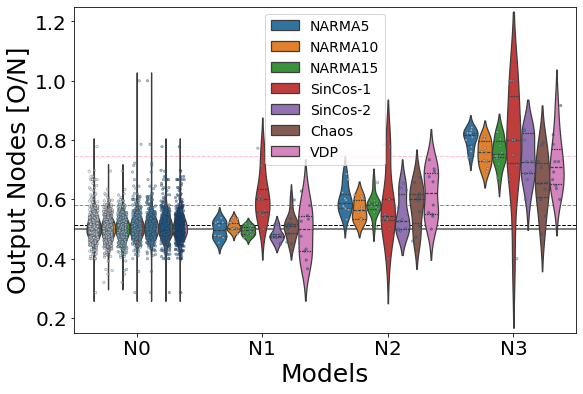

C:\Users\manis\AppData\Local\Temp\ipykernel_24692\3212046423.py:8: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  ax=sns.stripplot(y=df_All.columns[i], x="Models", hue='Task', data=df_All, jitter=0.25, dodge=True,\
C:\Users\manis\AppData\Local\Temp\ipykernel_24692\3212046423.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax=sns.violinplot(y=df_All.columns[i], x="Models", hue='Task', data=df_All,  scale="width", inner="quartiles")


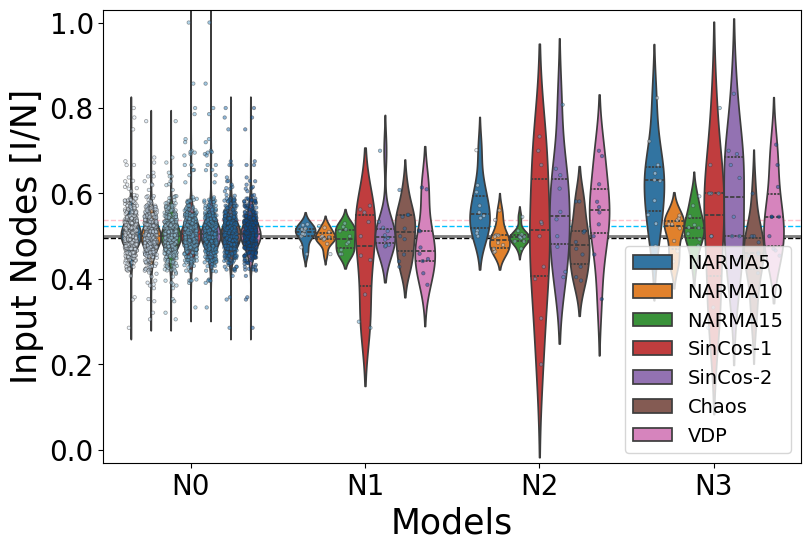

C:\Users\manis\AppData\Local\Temp\ipykernel_24692\3212046423.py:8: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  ax=sns.stripplot(y=df_All.columns[i], x="Models", hue='Task', data=df_All, jitter=0.25, dodge=True,\
C:\Users\manis\AppData\Local\Temp\ipykernel_24692\3212046423.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax=sns.violinplot(y=df_All.columns[i], x="Models", hue='Task', data=df_All,  scale="width", inner="quartiles")


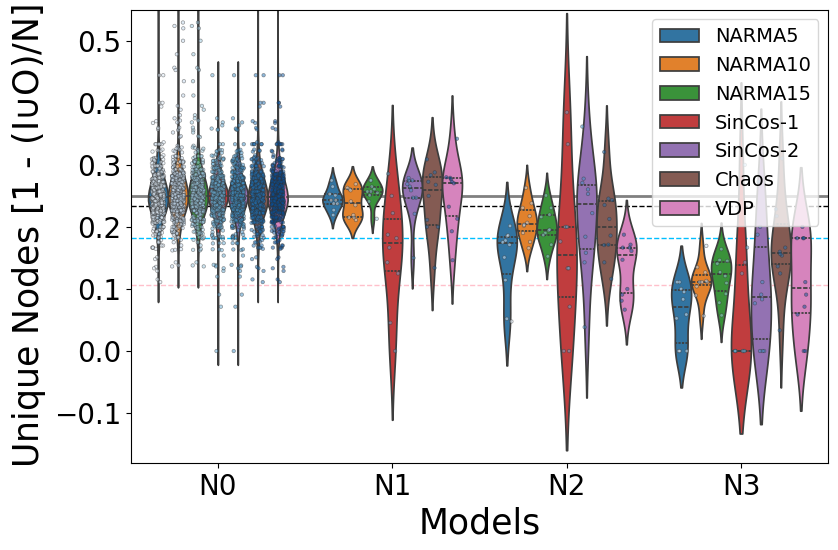

C:\Users\manis\AppData\Local\Temp\ipykernel_24692\3212046423.py:8: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  ax=sns.stripplot(y=df_All.columns[i], x="Models", hue='Task', data=df_All, jitter=0.25, dodge=True,\
C:\Users\manis\AppData\Local\Temp\ipykernel_24692\3212046423.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax=sns.violinplot(y=df_All.columns[i], x="Models", hue='Task', data=df_All,  scale="width", inner="quartiles")


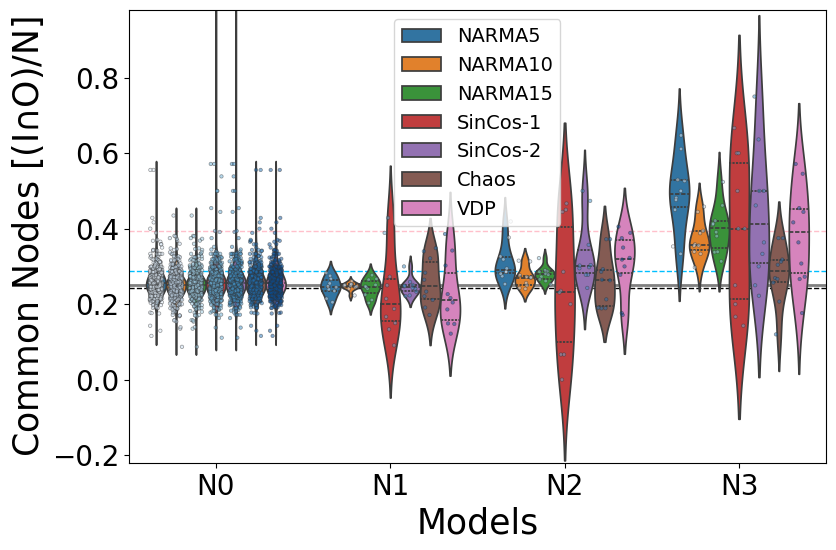

In [14]:
PlotDir = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/Manuscript/Figs/'

FrLabels=['Output Nodes [O/N]', 'Input Nodes [I/N]', 'Unique Nodes [1 - (I$\cup$O)/N]', 'Common Nodes [(I$\cap$O)/N]']
for i in range(2, 6):
    plt.figure(figsize=(9,6))
    plt.rcParams['figure.dpi'] = 100
    
    ax=sns.stripplot(y=df_All.columns[i], x="Models", hue='Task', data=df_All, jitter=0.25, dodge=True,\
                  palette='Blues',size=2.5, linewidth=0.5,edgecolor="gray", legend=None, alpha=0.5)
    ax=sns.violinplot(y=df_All.columns[i], x="Models", hue='Task', data=df_All,  scale="width", inner="quartiles")
    
        
    if i==5:
        ax.axhline(y=0.25, color='grey', linestyle='-', lw=2, alpha=1, zorder=-1)
        ax.set_ylim(-0.22,0.98)
        ax.axhline(y=FrCMean[1], color='k', linestyle='--', lw=1, alpha=1, zorder=-1)
        ax.axhline(y=FrCMean[2], color='deepskyblue', linestyle='--', lw=1, alpha=1, zorder=-1)
        ax.axhline(y=FrCMean[3], color='pink', linestyle='--', lw=1, alpha=1, zorder=-1)
    if i==4:
        ax.axhline(y=0.25, color='grey', linestyle='-', lw=2, alpha=1, zorder=-1)
        ax.set_ylim(-0.18,0.55)
        ax.axhline(y=FrUMean[1], color='k', linestyle='--', lw=1, alpha=1, zorder=-1)
        ax.axhline(y=FrUMean[2], color='deepskyblue', linestyle='--', lw=1, alpha=1, zorder=-1)
        ax.axhline(y=FrUMean[3], color='pink', linestyle='--', lw=1, alpha=1, zorder=-1)
    if i==3:
        ax.axhline(y=0.5, color='grey', linestyle='-', lw=2, alpha=1, zorder=-1)
        ax.axhline(y=FrInMean[1], color='k', linestyle='--', lw=1, alpha=1, zorder=-1)
        ax.axhline(y=FrInMean[2], color='deepskyblue', linestyle='--', lw=1, alpha=1, zorder=-1)
        ax.axhline(y=FrInMean[3], color='pink', linestyle='--', lw=1, alpha=1, zorder=-1)
        ax.set_ylim(-0.03,1.03)
    if i==2:
        ax.axhline(y=0.5, color='grey', linestyle='-', lw=2, alpha=1, zorder=-1)
        ax.axhline(y=FrOutMean[1], color='k', linestyle='--', lw=1, alpha=1, zorder=-1)
        ax.axhline(y=FrOutMean[2], color='deepskyblue', linestyle='--', lw=1, alpha=1, zorder=-1)
        ax.axhline(y=FrOutMean[3], color='pink', linestyle='--', lw=1, alpha=1, zorder=-1)
        ax.set_ylim(0.15,1.25)
        
    ax.tick_params(axis='both',labelsize=20)
    ax.set_ylabel(FrLabels[i-2],fontsize=25)
    ax.set_xlabel('Models',fontsize=25)
    plt.legend(loc='best',fontsize=14)
#     plt.savefig(os.path.join(PlotDir,'Fig7_{:}.svg'.format(i-2)), bbox_inches='tight')
    plt.show()

## Node and Performance: NARMA-5, 10 and 15

C:\Users\manis\AppData\Local\Temp\ipykernel_24692\3886584029.py:8: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  ax=sns.stripplot(y=df.columns[i], x="Models", hue='Task', data=df, jitter=0.25, dodge=True,\
C:\Users\manis\AppData\Local\Temp\ipykernel_24692\3886584029.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax=sns.violinplot(y=df.columns[i], x="Models", hue='Task', data=df, scale="width", inner="quartiles")


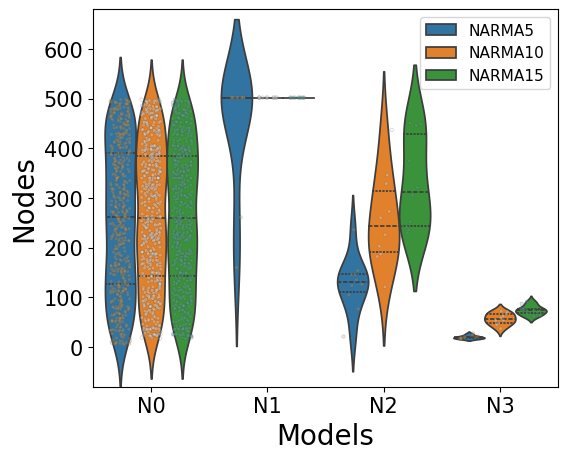

C:\Users\manis\AppData\Local\Temp\ipykernel_24692\3886584029.py:29: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax=sns.violinplot(y=df.columns[i], x="Models", hue='Task', data=df, scale="width", inner="quartiles", log_scale=True)


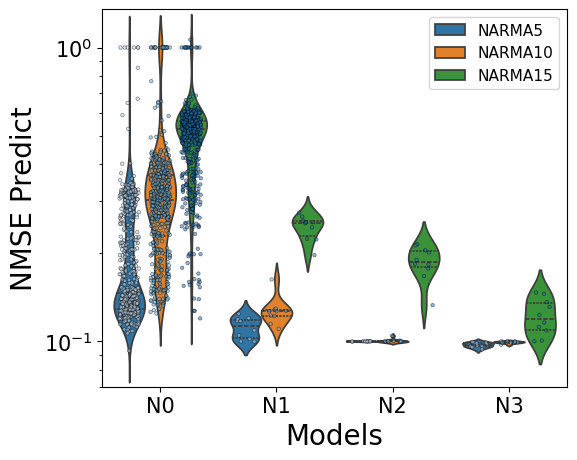

C:\Users\manis\AppData\Local\Temp\ipykernel_24692\3886584029.py:49: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax=sns.violinplot(y=df.columns[i], x="Models", hue='Task', data=df, scale="width", inner="quartiles", log_scale=True)


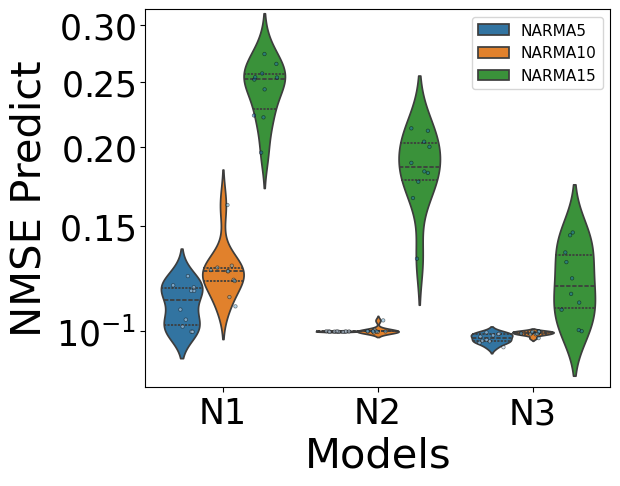

In [15]:
PlotDir = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/Manuscript/Figs/'

fig_size = plt.rcParams["figure.figsize"]  
plt.rcParams["figure.figsize"] = (6,5) 
plt.rcParams['figure.dpi'] = 100
i=6

ax=sns.stripplot(y=df.columns[i], x="Models", hue='Task', data=df, jitter=0.25, dodge=True,\
              palette='BrBG', size=2.5, linewidth=0.5,edgecolor="gray", legend=None, alpha=0.25)
ax=sns.violinplot(y=df.columns[i], x="Models", hue='Task', data=df, scale="width", inner="quartiles")
ax.set_ylim(-80,680)
ax.tick_params(axis='both',labelsize=15)
ax.set_ylabel(df.columns[i],fontsize=20)
ax.set_xlabel('Models',fontsize=20)
plt.legend(loc='best',fontsize=11)
# plt.savefig(os.path.join(PlotDir,'Fig3_a.svg'), bbox_inches='tight')
plt.show()

##################################################################################################
PlotDir = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/Manuscript/Figs/'

fig_size = plt.rcParams["figure.figsize"]  
plt.rcParams["figure.figsize"] = (6,5) 
plt.rcParams['figure.dpi'] = 100
i=12

ax=sns.stripplot(y=df.columns[i], x="Models", hue='Task', data=df, jitter=0.25, dodge=True,\
              palette='Blues', size=2.5, linewidth=0.5,edgecolor="black", legend=None, log_scale=True, alpha=0.5)
ax=sns.violinplot(y=df.columns[i], x="Models", hue='Task', data=df, scale="width", inner="quartiles", log_scale=True)
ax.set_ylim(0.07,1.35)
ax.tick_params(axis='both',labelsize=15)
ax.set_ylabel(df.columns[i],fontsize=20)
ax.set_xlabel('Models',fontsize=20)
plt.legend(loc='best',fontsize=11)
# plt.savefig(os.path.join(PlotDir,'Fig3_b1.svg'), bbox_inches='tight')

plt.show()

#######################################################################################
PlotDir = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/Manuscript/Figs/'

fig_size = plt.rcParams["figure.figsize"]  
plt.rcParams["figure.figsize"] = (6,5) 
plt.rcParams['figure.dpi'] = 100
i=12

ax=sns.stripplot(y=df.columns[i], x="Models", hue='Task', data=df, jitter=0.25, dodge=True,\
              palette='Blues', size=2.5, linewidth=0.5,edgecolor="black", legend=None, alpha=0.5)
ax=sns.violinplot(y=df.columns[i], x="Models", hue='Task', data=df, scale="width", inner="quartiles", log_scale=True)
ax.set_ylim(0.08,0.315)
ax.tick_params(axis='both',labelsize=25)
ax.set_ylabel(df.columns[i],fontsize=30)
ax.set_xlabel('Models',fontsize=30)
plt.legend(loc='best',fontsize=11)
plt.xlim(0.5, 3.5)
ax.set_yscale('logit')
# plt.savefig(os.path.join(PlotDir,'Fig3_b2.svg'), bbox_inches='tight')

plt.show()

## Node and Performance: SinCos-1 and 2

C:\Users\manis\AppData\Local\Temp\ipykernel_24692\1279023449.py:6: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  ax=sns.stripplot(y=dfSC.columns[i], x="Models", hue='Task', data=dfSC, jitter=0.25, dodge=True,\
C:\Users\manis\AppData\Local\Temp\ipykernel_24692\1279023449.py:8: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax=sns.violinplot(y=dfSC.columns[i], x="Models", hue='Task', data=dfSC, scale="width", inner="quartiles", log_scale=True)


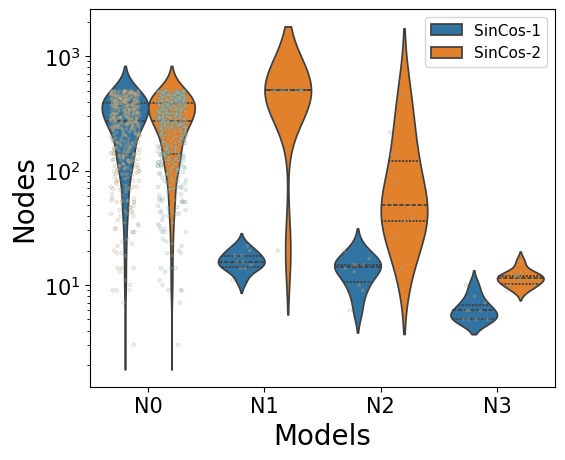

C:\Users\manis\AppData\Local\Temp\ipykernel_24692\1279023449.py:28: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax=sns.violinplot(y=dfSC.columns[i], x="Models", hue='Task', data=dfSC, scale="width", inner="quartiles", log_scale=True)


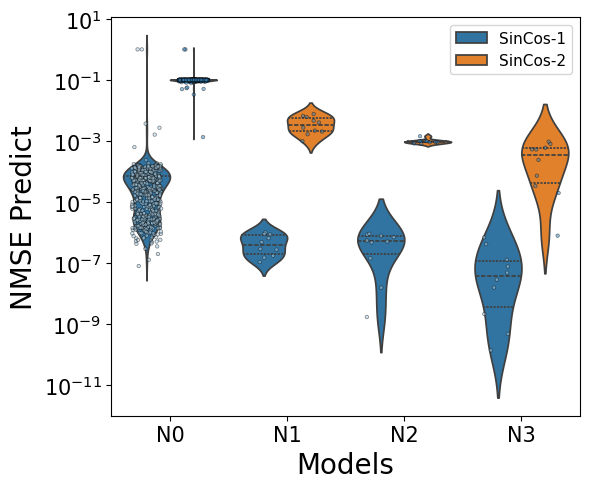

In [16]:
fig_size = plt.rcParams["figure.figsize"]  
plt.rcParams["figure.figsize"] = (6,5) 
plt.rcParams['figure.dpi'] = 100
i=6

ax=sns.stripplot(y=dfSC.columns[i], x="Models", hue='Task', data=dfSC, jitter=0.25, dodge=True,\
              palette='BrBG', size=2.5, linewidth=0.5,edgecolor="gray", legend=None, alpha=0.25, log_scale=True)
ax=sns.violinplot(y=dfSC.columns[i], x="Models", hue='Task', data=dfSC, scale="width", inner="quartiles", log_scale=True)
# ax.set_ylim(1,950)
ax.tick_params(axis='both',labelsize=15)
ax.set_ylabel(dfSC.columns[i],fontsize=20)
ax.set_xlabel('Models',fontsize=20)
plt.legend(loc='best',fontsize=11)
# plt.savefig(os.path.join(PlotDir,'Fig4_b.svg'), bbox_inches='tight')

plt.show()

##################################################################
PlotDir = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/Manuscript/Figs/'

fig_size = plt.rcParams["figure.figsize"]  
plt.rcParams["figure.figsize"] = (6,5) 
plt.rcParams['figure.dpi'] = 100
i=12

ax=sns.stripplot(y=dfSC.columns[i], x="Models", hue='Task', data=dfSC, jitter=0.25, dodge=True,\
              palette='Blues', size=2.5, linewidth=0.5,edgecolor="black", legend=None, alpha=0.5, log_scale=True)
ax=sns.violinplot(y=dfSC.columns[i], x="Models", hue='Task', data=dfSC, scale="width", inner="quartiles", log_scale=True)

ax.tick_params(axis='both',labelsize=15)
ax.set_ylabel(dfSC.columns[i],fontsize=20)
ax.set_xlabel('Models',fontsize=20)

plt.tight_layout()
plt.legend(loc='best',fontsize=11)
# plt.savefig(os.path.join(PlotDir,'Fig4_c.svg'), bbox_inches='tight')

plt.show()

## Node and Performance: Chaos and Van der Pol oscillator

C:\Users\manis\AppData\Local\Temp\ipykernel_24692\3947940142.py:6: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  ax=sns.stripplot(y=dfCV.columns[i], x="Models", hue='Task', data=dfCV, jitter=0.25, dodge=True,\
C:\Users\manis\AppData\Local\Temp\ipykernel_24692\3947940142.py:8: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax=sns.violinplot(y=dfCV.columns[i], x="Models", hue='Task', data=dfCV, scale="width", inner="quartiles", log_scale=True)


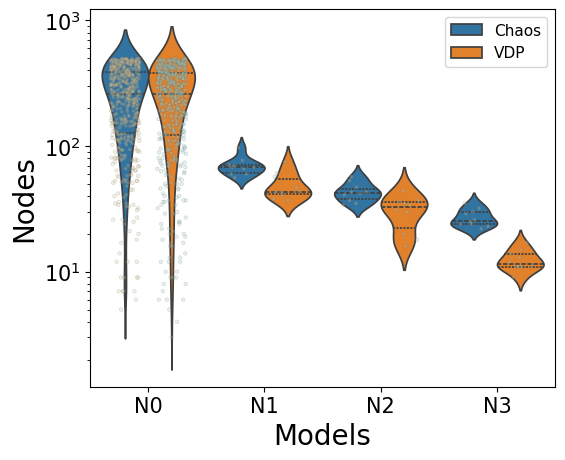

C:\Users\manis\AppData\Local\Temp\ipykernel_24692\3947940142.py:27: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax=sns.violinplot(y=dfCV.columns[i], x="Models", hue='Task', data=dfCV, scale="width", inner="quartiles", log_scale=True)


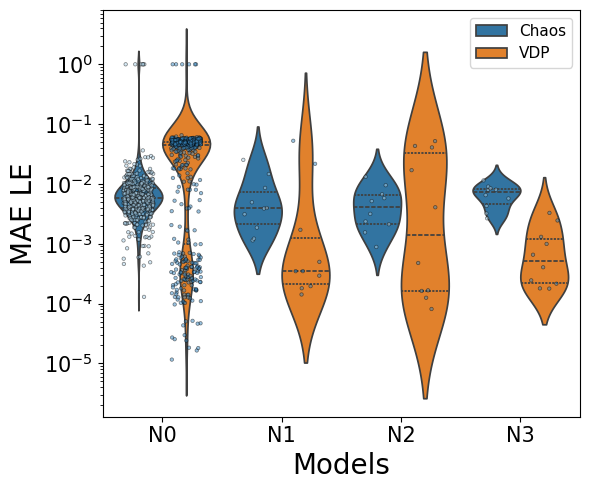

In [17]:
fig_size = plt.rcParams["figure.figsize"]  
plt.rcParams["figure.figsize"] = (6,5) 
plt.rcParams['figure.dpi'] = 100
i=6

ax=sns.stripplot(y=dfCV.columns[i], x="Models", hue='Task', data=dfCV, jitter=0.25, dodge=True,\
              palette='BrBG', size=2.5, linewidth=0.5,edgecolor="gray", legend=None, alpha=0.25, log_scale=True)
ax=sns.violinplot(y=dfCV.columns[i], x="Models", hue='Task', data=dfCV, scale="width", inner="quartiles", log_scale=True)
# ax.set_ylim(1,950)
ax.tick_params(axis='both',labelsize=15)
ax.set_ylabel(dfCV.columns[i],fontsize=20)
ax.set_xlabel('Models',fontsize=20)
plt.legend(loc='best',fontsize=11)
# plt.savefig(os.path.join(PlotDir,'Fig5_b.svg'), bbox_inches='tight')

plt.show()
##################################################################################################
PlotDir = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/Manuscript/Figs/'

fig_size = plt.rcParams["figure.figsize"]  
plt.rcParams["figure.figsize"] = (6,5) 
plt.rcParams['figure.dpi'] = 100
i=14 

ax=sns.stripplot(y=dfCV.columns[i], x="Models", hue='Task', data=dfCV, jitter=0.25, dodge=True,\
              palette='Blues', size=2.5, linewidth=0.5,edgecolor="black", legend=None, alpha=0.5, log_scale=True)
ax=sns.violinplot(y=dfCV.columns[i], x="Models", hue='Task', data=dfCV, scale="width", inner="quartiles", log_scale=True)
ax.tick_params(axis='both',labelsize=15)
ax.set_ylabel(dfCV.columns[i],fontsize=20)
ax.set_xlabel('Models',fontsize=20)
plt.tight_layout()
plt.legend(loc='best',fontsize=11)
# plt.savefig(os.path.join(PlotDir,'Fig5_c.svg'), bbox_inches='tight')

plt.show()

C:\Users\manis\AppData\Local\Temp\ipykernel_24692\1242562434.py:8: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  ax=sns.stripplot(y='NMSE Predict', x="Models", hue='Task', data=df[(df.Task=='NARMA5')&(df.Models=='N0')], jitter=0.2, dodge=True,\
C:\Users\manis\AppData\Local\Temp\ipykernel_24692\1242562434.py:10: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  ax=sns.stripplot(y='NMSE Predict', x="Models", hue='Task', data=df[(df.Task=='NARMA5')&(df.Models!='N0')], jitter=0.2, dodge=True,\
C:\Users\manis\AppData\Local\Temp\ipykernel_24692\1242562434.py:12: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax=sns.violinplot(y='NMSE Predict', x="Models", data=df[(df.Task=='NARMA5')], color=sns.color_palette()[0], scale="width", inner="quartiles")


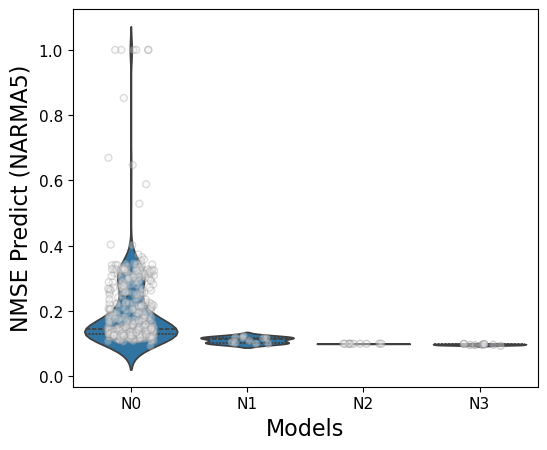

C:\Users\manis\AppData\Local\Temp\ipykernel_24692\1242562434.py:22: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  ax=sns.stripplot(y='NMSE Predict', x="Models", hue='Task', data=df[(df.Task=='NARMA5')&(df.Models=='N0')], jitter=0.2, dodge=True,\
C:\Users\manis\AppData\Local\Temp\ipykernel_24692\1242562434.py:24: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  ax=sns.stripplot(y='NMSE Predict', x="Models", hue='Task', data=df[(df.Task=='NARMA5')&(df.Models!='N0')], jitter=0.2, dodge=True,\
C:\Users\manis\AppData\Local\Temp\ipykernel_24692\1242562434.py:26: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax=sns.violinplot(y='NMSE Predict', x="Models", data=df[(df.Task=='NARMA5')], color=sns.color_palette()[0],  scale="width", inner="quartiles")


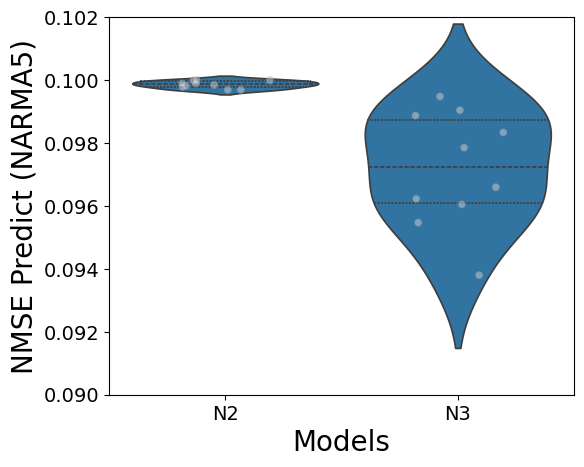

C:\Users\manis\AppData\Local\Temp\ipykernel_24692\1242562434.py:35: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  ax=sns.stripplot(y='NMSE Predict', x="Models", hue='Task', data=df[(df.Task=='NARMA10')&(df.Models=='N0')], jitter=0.2, dodge=True,\
C:\Users\manis\AppData\Local\Temp\ipykernel_24692\1242562434.py:37: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  ax=sns.stripplot(y='NMSE Predict', x="Models", hue='Task', data=df[(df.Task=='NARMA10')&(df.Models!='N0')], jitter=0.2, dodge=True,\
C:\Users\manis\AppData\Local\Temp\ipykernel_24692\1242562434.py:39: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax=sns.violinplot(y='NMSE Predict', x="Models", data=df[(df.Task=='NARMA10')], color=sns.color_palette()[0], scale="width", inner="quartiles"

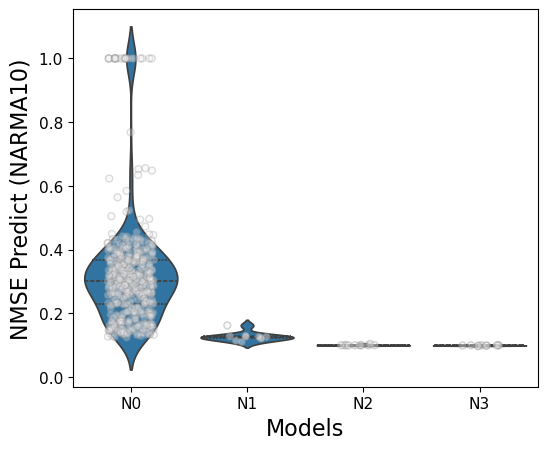

C:\Users\manis\AppData\Local\Temp\ipykernel_24692\1242562434.py:50: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  ax=sns.stripplot(y='NMSE Predict', x="Models", hue='Task', data=df[(df.Task=='NARMA10')&(df.Models=='N0')], jitter=0.2, dodge=True,\
C:\Users\manis\AppData\Local\Temp\ipykernel_24692\1242562434.py:52: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  ax=sns.stripplot(y='NMSE Predict', x="Models", hue='Task', data=df[(df.Task=='NARMA10')&(df.Models!='N0')], jitter=0.2, dodge=True,\
C:\Users\manis\AppData\Local\Temp\ipykernel_24692\1242562434.py:54: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax=sns.violinplot(y='NMSE Predict', x="Models", data=df[(df.Task=='NARMA10')], color=sns.color_palette()[0],  scale="width", inner="quartiles

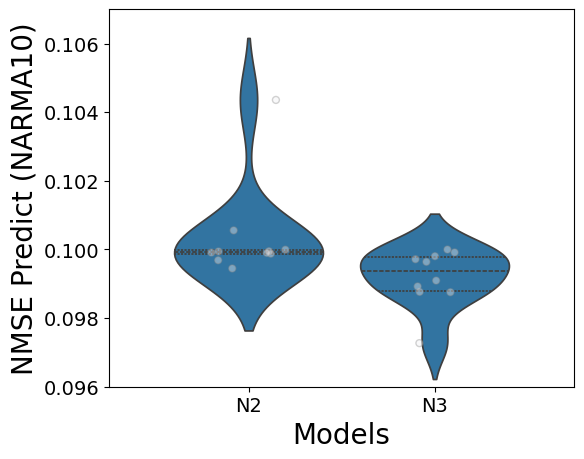

C:\Users\manis\AppData\Local\Temp\ipykernel_24692\1242562434.py:63: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  ax=sns.stripplot(y='NMSE Predict', x="Models", hue='Task', data=df[(df.Task=='NARMA15')&(df.Models=='N0')], jitter=0.2, dodge=True,\
C:\Users\manis\AppData\Local\Temp\ipykernel_24692\1242562434.py:65: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  ax=sns.stripplot(y='NMSE Predict', x="Models", hue='Task', data=df[(df.Task=='NARMA15')&(df.Models!='N0')], jitter=0.2, dodge=True,\
C:\Users\manis\AppData\Local\Temp\ipykernel_24692\1242562434.py:67: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax=sns.violinplot(y='NMSE Predict', x="Models", data=df[(df.Task=='NARMA15')], color=sns.color_palette()[1],  scale="width", inner="quartiles

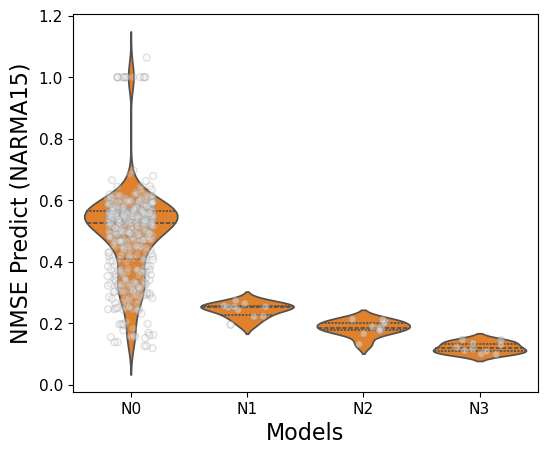

In [18]:
# Function x**(1/2)
def forward(x):
    return x**(1/(10**12))
def inverse(x):
    return x**(10**12)

plt.figure(figsize=(6,5))
ax=sns.stripplot(y='NMSE Predict', x="Models", hue='Task', data=df[(df.Task=='NARMA5')&(df.Models=='N0')], jitter=0.2, dodge=True,\
              palette='light:b',linewidth=1,edgecolor="gray", legend=None, alpha=0.3)
ax=sns.stripplot(y='NMSE Predict', x="Models", hue='Task', data=df[(df.Task=='NARMA5')&(df.Models!='N0')], jitter=0.2, dodge=True,\
              palette='light:b',linewidth=1,edgecolor="gray", legend=None, alpha=0.4)
ax=sns.violinplot(y='NMSE Predict', x="Models", data=df[(df.Task=='NARMA5')], color=sns.color_palette()[0], scale="width", inner="quartiles")
plt.ylabel('NMSE Predict (NARMA5)',fontsize=16)
ax.tick_params(axis='both',labelsize=11)
ax.set_xlabel('Models',fontsize=16)
# plt.ylim(0.03, 1)
# plt.yscale('function', functions=(forward, inverse))
# plt.yscale('logit')
plt.show()

plt.figure(figsize=(6,5))
ax=sns.stripplot(y='NMSE Predict', x="Models", hue='Task', data=df[(df.Task=='NARMA5')&(df.Models=='N0')], jitter=0.2, dodge=True,\
              palette='light:b',linewidth=1,edgecolor="gray", legend=None, alpha=0.4)
ax=sns.stripplot(y='NMSE Predict', x="Models", hue='Task', data=df[(df.Task=='NARMA5')&(df.Models!='N0')], jitter=0.2, dodge=True,\
              palette='light:b',linewidth=1,edgecolor="gray", legend=None, alpha=0.4)
ax=sns.violinplot(y='NMSE Predict', x="Models", data=df[(df.Task=='NARMA5')], color=sns.color_palette()[0],  scale="width", inner="quartiles")
plt.ylabel('NMSE Predict (NARMA5)',fontsize=20)
ax.tick_params(axis='both',labelsize=14)
ax.set_xlabel('Models',fontsize=20)
plt.ylim(0.09, 0.102)
plt.xlim(1.5,3.5)
plt.show()

plt.figure(figsize=(6,5))
ax=sns.stripplot(y='NMSE Predict', x="Models", hue='Task', data=df[(df.Task=='NARMA10')&(df.Models=='N0')], jitter=0.2, dodge=True,\
              palette='light:b',linewidth=1,edgecolor="gray", legend=None, alpha=0.3)
ax=sns.stripplot(y='NMSE Predict', x="Models", hue='Task', data=df[(df.Task=='NARMA10')&(df.Models!='N0')], jitter=0.2, dodge=True,\
              palette='light:b',linewidth=1,edgecolor="gray", legend=None, alpha=0.4)
ax=sns.violinplot(y='NMSE Predict', x="Models", data=df[(df.Task=='NARMA10')], color=sns.color_palette()[0], scale="width", inner="quartiles")
plt.ylabel('NMSE Predict (NARMA10)',fontsize=16)
ax.tick_params(axis='both',labelsize=11)
ax.set_xlabel('Models',fontsize=16)
# plt.ylim(0.096, 0.107)
# plt.xlim(1.25,3.75)
# plt.yscale('function', functions=(forward, inverse))
# plt.yscale('logit')
plt.show()

plt.figure(figsize=(6,5))
ax=sns.stripplot(y='NMSE Predict', x="Models", hue='Task', data=df[(df.Task=='NARMA10')&(df.Models=='N0')], jitter=0.2, dodge=True,\
              palette='light:b',linewidth=1,edgecolor="gray", legend=None, alpha=0.4)
ax=sns.stripplot(y='NMSE Predict', x="Models", hue='Task', data=df[(df.Task=='NARMA10')&(df.Models!='N0')], jitter=0.2, dodge=True,\
              palette='light:b',linewidth=1,edgecolor="gray", legend=None, alpha=0.4)
ax=sns.violinplot(y='NMSE Predict', x="Models", data=df[(df.Task=='NARMA10')], color=sns.color_palette()[0],  scale="width", inner="quartiles")
plt.ylabel('NMSE Predict (NARMA10)',fontsize=20)
ax.tick_params(axis='both',labelsize=14)
ax.set_xlabel('Models',fontsize=20)
plt.ylim(0.096, 0.107)
plt.xlim(1.25,3.75)
plt.show()

plt.figure(figsize=(6,5))
ax=sns.stripplot(y='NMSE Predict', x="Models", hue='Task', data=df[(df.Task=='NARMA15')&(df.Models=='N0')], jitter=0.2, dodge=True,\
              palette='light:b',linewidth=1,edgecolor="gray", legend=None, alpha=0.25)
ax=sns.stripplot(y='NMSE Predict', x="Models", hue='Task', data=df[(df.Task=='NARMA15')&(df.Models!='N0')], jitter=0.2, dodge=True,\
              palette='light:b',linewidth=1,edgecolor="gray", legend=None, alpha=0.4)
ax=sns.violinplot(y='NMSE Predict', x="Models", data=df[(df.Task=='NARMA15')], color=sns.color_palette()[1],  scale="width", inner="quartiles")
plt.ylabel('NMSE Predict (NARMA15)',fontsize=16)
ax.tick_params(axis='both',labelsize=11)
ax.set_xlabel('Models',fontsize=16)
plt.show()

## Nodes vs Density plots

In [20]:
import matplotlib.colors as colors

def NodesVsProp_Plot(df, Task, NetPropX, NetPropY, NetPropZ, ClrBar_range, Xlim, Ylim):
    fig_size = plt.rcParams["figure.figsize"]  
    plt.rcParams["figure.figsize"] = (6,5) 
    plt.rcParams['figure.dpi'] = 100
    
    fig, ax = plt.subplots(1, 1)

    ax1=ax.scatter(df[NetPropX][(df.Task==Task)&(df.Models=='N0')], df[NetPropY][(df.Task==Task)&(df.Models=='N0')], s=30, alpha=0.6,\
               marker='o', c=df[NetPropZ][(df.Task==Task)&(df.Models=='N0')], cmap="rainbow",\
                   norm=colors.LogNorm(vmin=ClrBar_range[0], vmax=ClrBar_range[1]), label='N0')
    ax2=ax.scatter(df[NetPropX][(df.Task==Task)&(df.Models=='N1')], df[NetPropY][(df.Task==Task)&(df.Models=='N1')], s=100, alpha=0.8,\
               marker='X', c=df[NetPropZ][(df.Task==Task)&(df.Models=='N1')], cmap="rainbow",\
                   norm=colors.LogNorm(vmin=ClrBar_range[0], vmax=ClrBar_range[1]), edgecolors='k', linewidth=1, label='N1')
    ax3=ax.scatter(df[NetPropX][(df.Task==Task)&(df.Models=='N2')], df[NetPropY][(df.Task==Task)&(df.Models=='N2')], s=150, alpha=0.8,\
               marker='*', c=df[NetPropZ][(df.Task==Task)&(df.Models=='N2')], cmap="rainbow",\
                   norm=colors.LogNorm(vmin=ClrBar_range[0], vmax=ClrBar_range[1]), edgecolors='k', linewidth=1, label='N2')
    ax4=ax.scatter(df[NetPropX][(df.Task==Task)&(df.Models=='N3')], df[NetPropY][(df.Task==Task)&(df.Models=='N3')], s=50, alpha=0.8,\
               marker='s', c=df[NetPropZ][(df.Task==Task)&(df.Models=='N3')], cmap="rainbow",\
                   norm=colors.LogNorm(vmin=ClrBar_range[0], vmax=ClrBar_range[1]), edgecolors='k', linewidth=1, label='N3')

    fig.colorbar(ax4,ax=ax,orientation='vertical',label='{:} {:}'.format(NetPropZ, Task))
    ax.set_xlabel('{:}'.format(NetPropX), fontsize=20)
    plt.ylabel('{:}'.format(NetPropY), fontsize=20)
    legend=ax.legend(fontsize=13, loc='upper right')#, bbox_to_anchor=(1.6, 1.02))  
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((0, 0, 1, 0.1))
    ax.tick_params(axis='both',labelsize=15)
    plt.xlim(Xlim[0], Xlim[1])
    plt.ylim(Ylim[0], Ylim[1])
#     plt.savefig(os.path.join(PlotDir,'Fig5_e.svg'), bbox_inches='tight')
    plt.show()

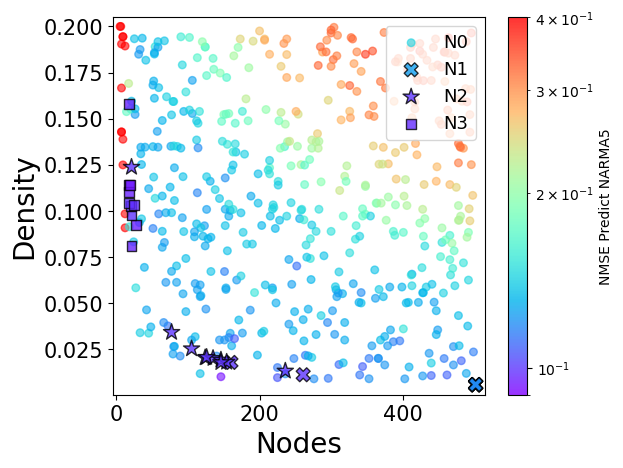

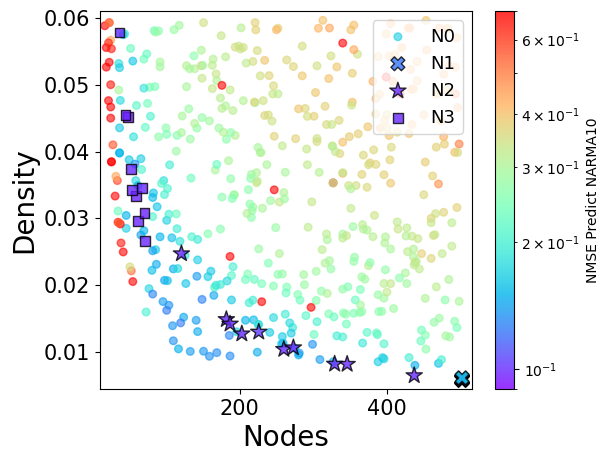

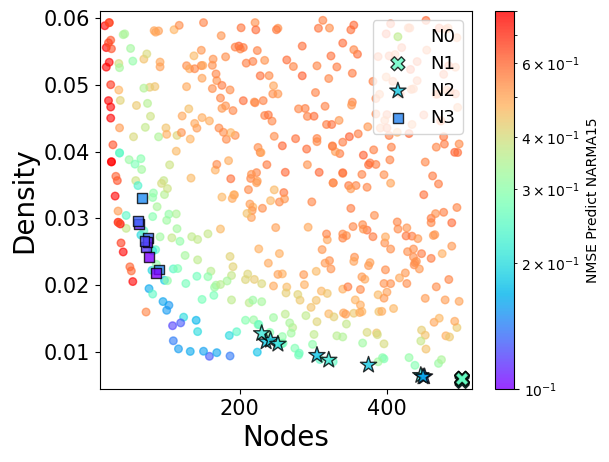

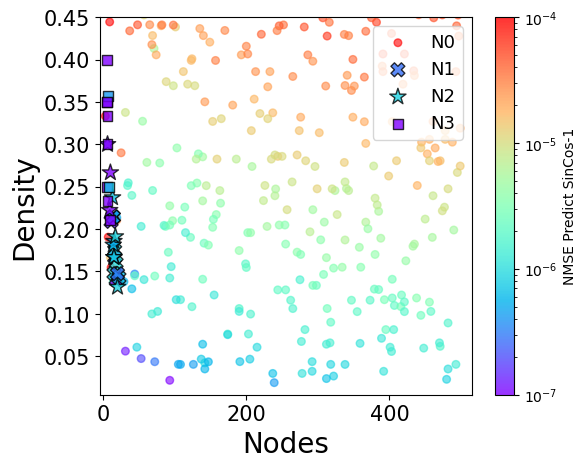

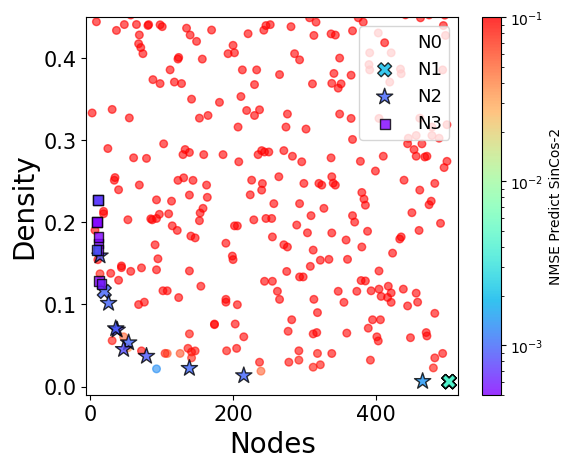

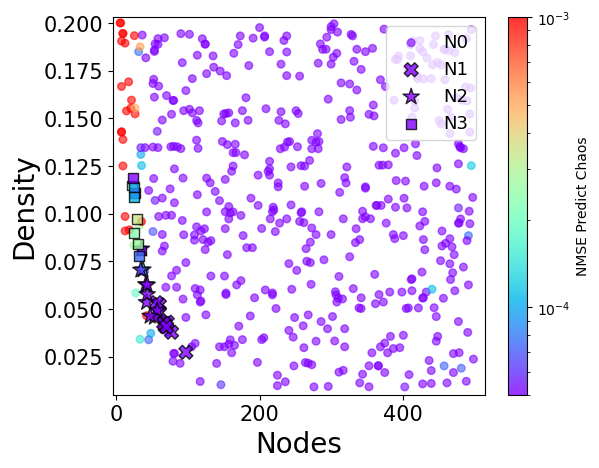

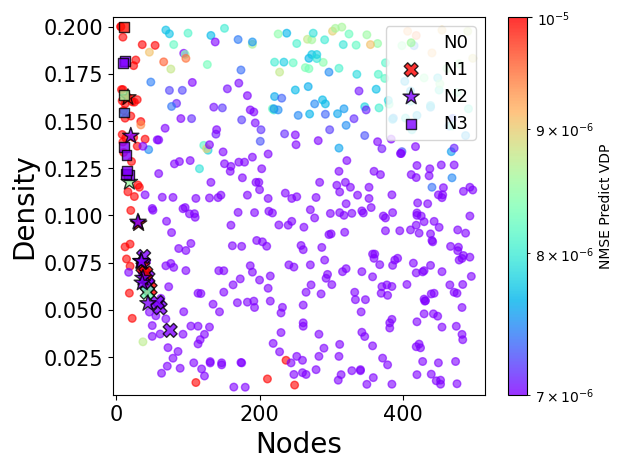

In [21]:
NodesVsProp_Plot(df, 'NARMA5', 'Nodes', 'Density', 'NMSE Predict', [0.09, 0.4], Xlim=[-5,515], Ylim=[0.0005, 0.205])
NodesVsProp_Plot(df, 'NARMA10', 'Nodes', 'Density', 'NMSE Predict', [0.09, 0.7], Xlim=[10,515], Ylim=[0.0045, 0.061])
NodesVsProp_Plot(df, 'NARMA15', 'Nodes', 'Density', 'NMSE Predict', [0.1, 0.8], Xlim=[10,515], Ylim=[0.0045, 0.061])

NodesVsProp_Plot(dfSC, 'SinCos-1', 'Nodes', 'Density', 'NMSE Predict', [0.0000001, 0.0001], Xlim=[-5,515], Ylim=[0.0045, 0.45])
NodesVsProp_Plot(dfSC, 'SinCos-2', 'Nodes', 'Density', 'NMSE Predict', [0.0005, 0.1], Xlim=[-5,515], Ylim=[-0.01, 0.45])

NodesVsProp_Plot(dfCV, 'Chaos', 'Nodes', 'Density', 'NMSE Predict', [0.00005, 0.001], Xlim=[-5,515], Ylim=[0.005, 0.203])
NodesVsProp_Plot(dfCV, 'VDP', 'Nodes', 'Density', 'NMSE Predict', [0.000007, 0.00001], Xlim=[-5,515], Ylim=[0.005, 0.205])

## Other Network measures

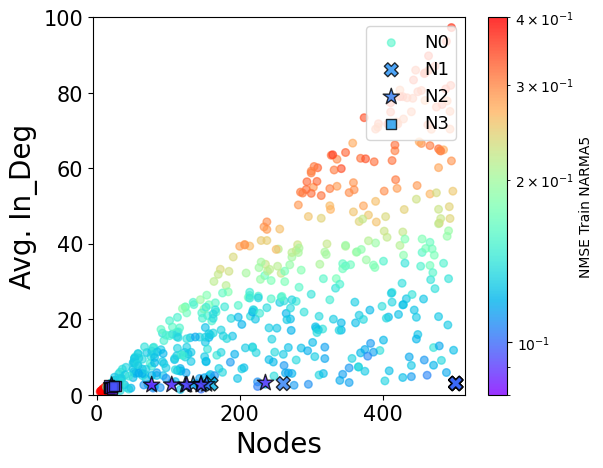

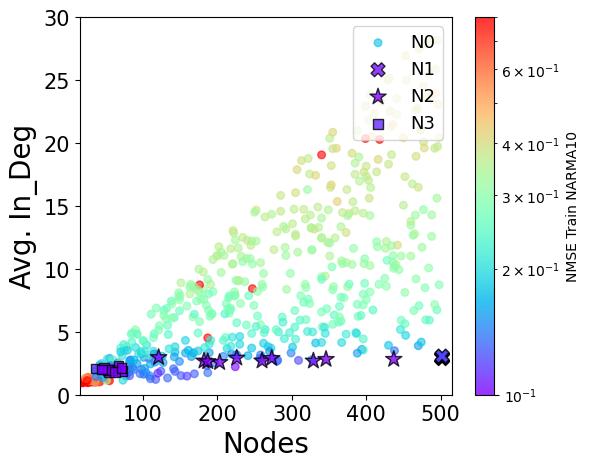

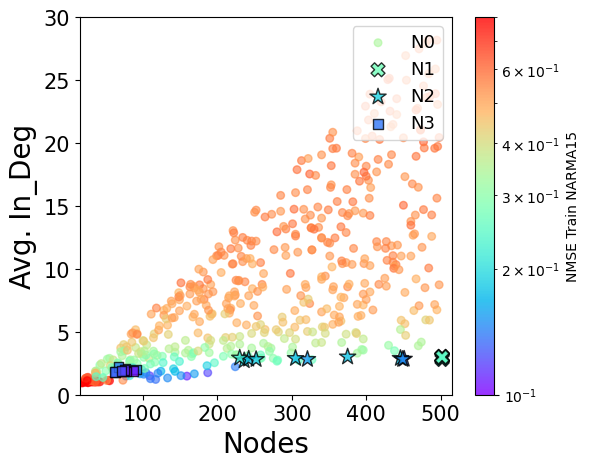

In [22]:
NodesVsProp_Plot(df, 'NARMA5', 'Nodes', 'Avg. In_Deg', 'NMSE Train', [0.08, 0.4], Xlim=[-5,515], Ylim=[0, 100])
NodesVsProp_Plot(df, 'NARMA10', 'Nodes', 'Avg. In_Deg', 'NMSE Train', [0.1, 0.8], Xlim=[15,515], Ylim=[0, 30])
NodesVsProp_Plot(df, 'NARMA15', 'Nodes', 'Avg. In_Deg', 'NMSE Train', [0.1, 0.8], Xlim=[15,515], Ylim=[0, 30])

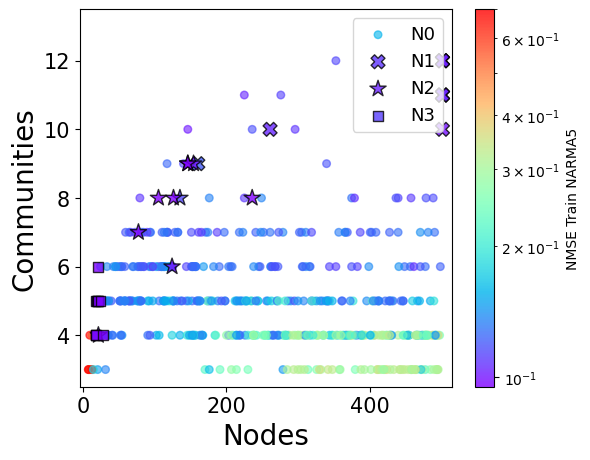

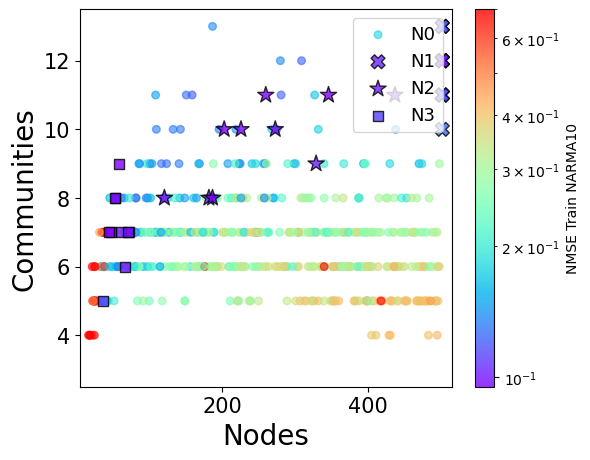

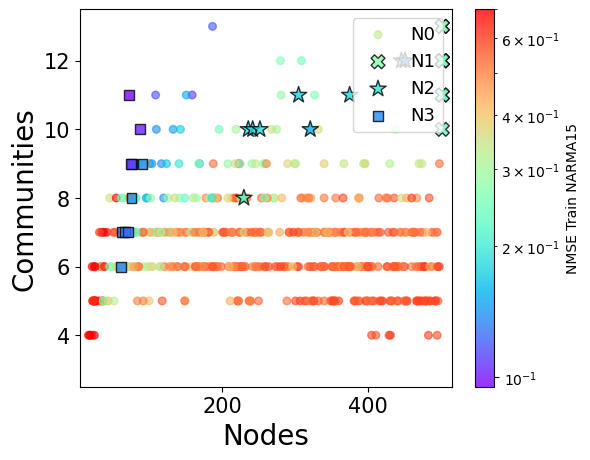

In [23]:
NodesVsProp_Plot(df, 'NARMA5', 'Nodes', 'Communities', 'NMSE Train', [0.095, 0.7], Xlim=[-5,515], Ylim=[2.5, 13.5])
NodesVsProp_Plot(df, 'NARMA10', 'Nodes', 'Communities', 'NMSE Train', [0.095, 0.7], Xlim=[5,515], Ylim=[2.5, 13.5])
NodesVsProp_Plot(df, 'NARMA15', 'Nodes', 'Communities', 'NMSE Train', [0.095, 0.7], Xlim=[5,515], Ylim=[2.5, 13.5])

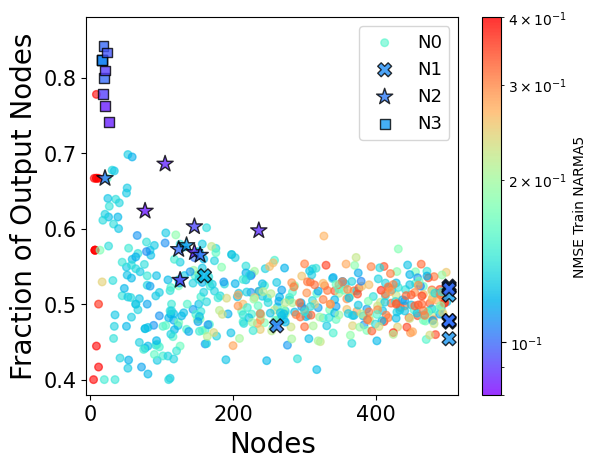

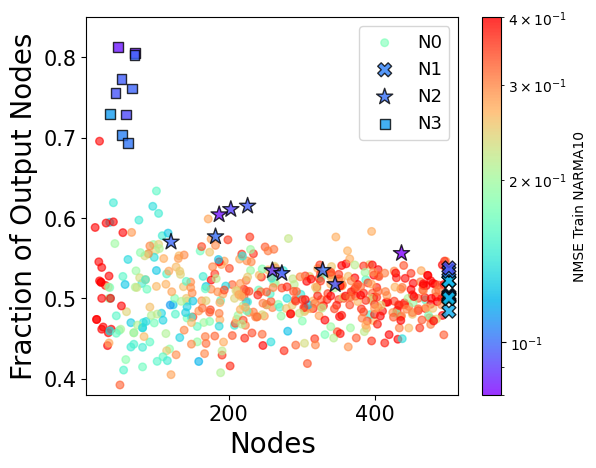

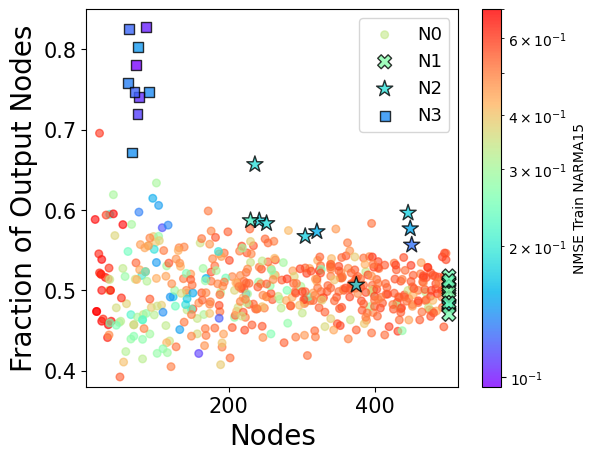

In [24]:
NodesVsProp_Plot(df, 'NARMA5', 'Nodes', 'Fraction of Output Nodes', 'NMSE Train', [0.08, 0.4], Xlim=[-5, 515], Ylim=[0.38,0.88])
NodesVsProp_Plot(df, 'NARMA10', 'Nodes', 'Fraction of Output Nodes', 'NMSE Train', [0.08, 0.4], Xlim=[5, 515], Ylim=[0.38,0.85])
NodesVsProp_Plot(df, 'NARMA15', 'Nodes', 'Fraction of Output Nodes', 'NMSE Train', [0.095, 0.7], Xlim=[5, 515], Ylim=[0.38,0.85])

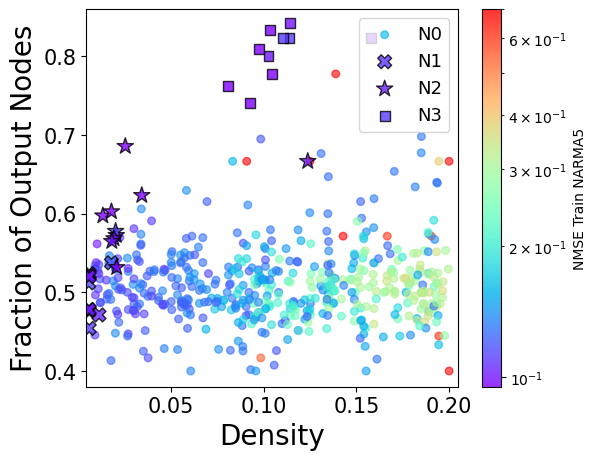

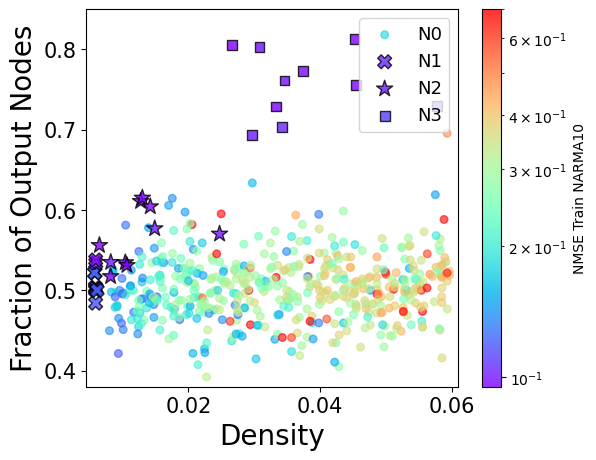

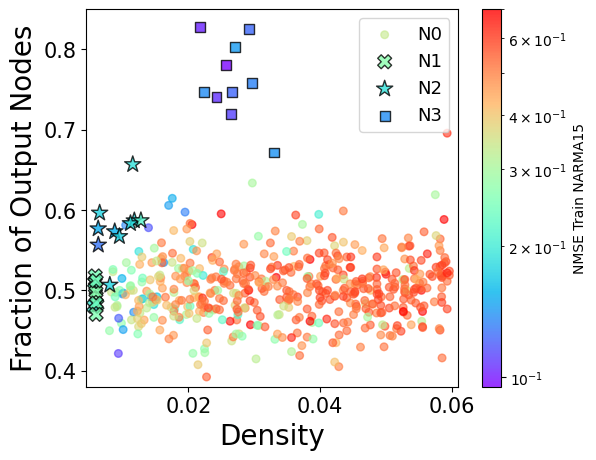

In [25]:
NodesVsProp_Plot(df, 'NARMA5', 'Density', 'Fraction of Output Nodes', 'NMSE Train', [0.095, 0.7], Xlim=[0.0045, 0.205], Ylim=[0.38,0.86])
NodesVsProp_Plot(df, 'NARMA10', 'Density', 'Fraction of Output Nodes', 'NMSE Train', [0.095, 0.7], Xlim=[0.0045, 0.061], Ylim=[0.38,0.85])
NodesVsProp_Plot(df, 'NARMA15', 'Density', 'Fraction of Output Nodes', 'NMSE Train', [0.095, 0.7], Xlim=[0.0045, 0.061], Ylim=[0.38,0.85])

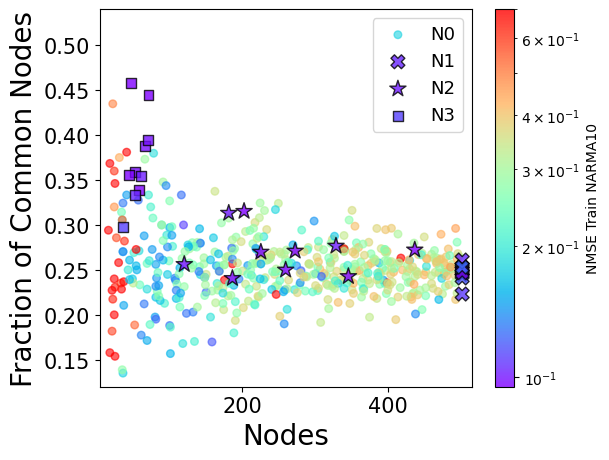

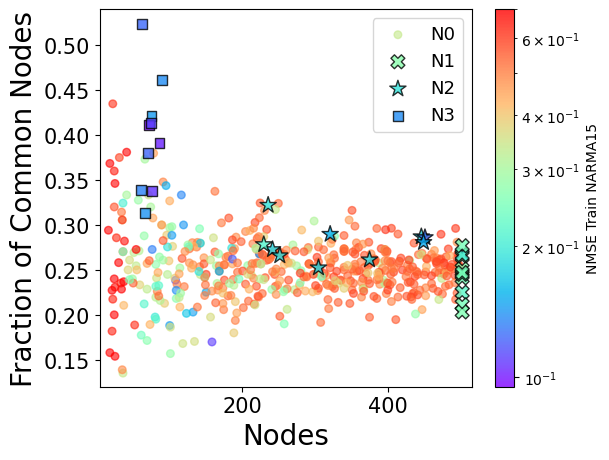

In [26]:
NodesVsProp_Plot(df, 'NARMA10', 'Nodes', 'Fraction of Common Nodes', 'NMSE Train', [0.095, 0.7], Xlim=[5, 515], Ylim=[0.12,0.54])
NodesVsProp_Plot(df, 'NARMA15', 'Nodes', 'Fraction of Common Nodes', 'NMSE Train', [0.095, 0.7], Xlim=[5, 515], Ylim=[0.12,0.54])

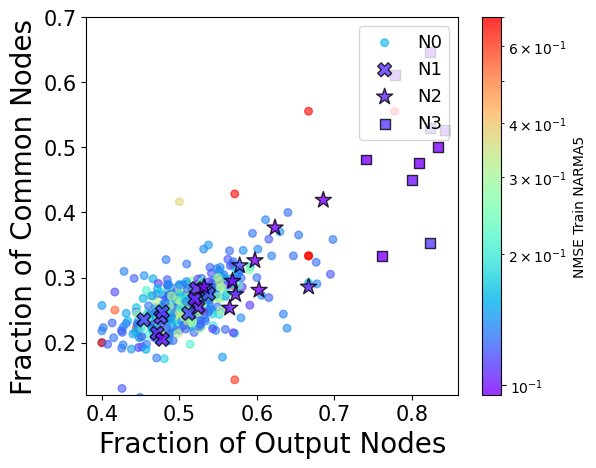

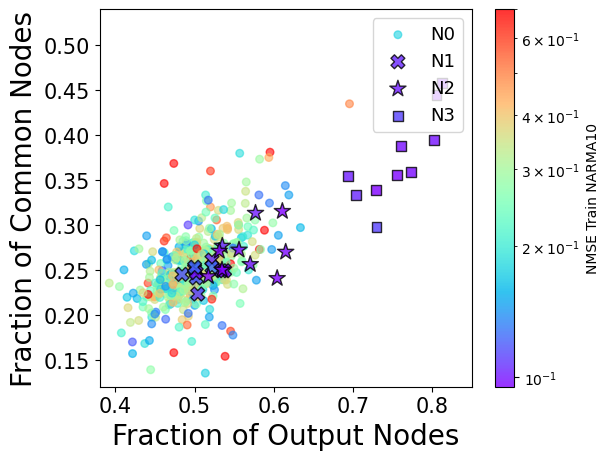

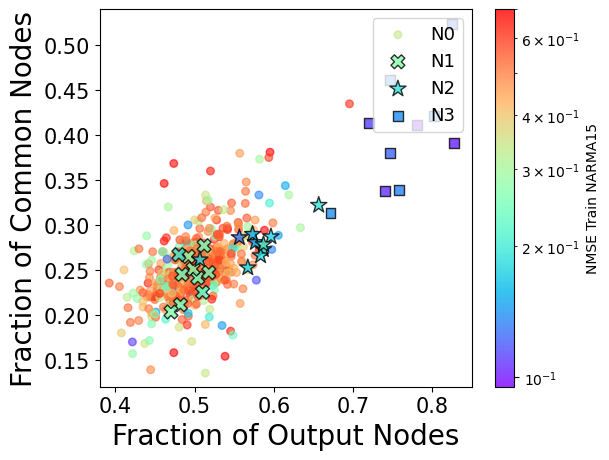

In [27]:
NodesVsProp_Plot(df, 'NARMA5', 'Fraction of Output Nodes', 'Fraction of Common Nodes', 'NMSE Train', [0.095, 0.7], Xlim=[0.38,0.86], Ylim=[0.12,0.7])
NodesVsProp_Plot(df, 'NARMA10', 'Fraction of Output Nodes', 'Fraction of Common Nodes', 'NMSE Train', [0.095, 0.7], Xlim=[0.38,0.85], Ylim=[0.12,0.54])
NodesVsProp_Plot(df, 'NARMA15', 'Fraction of Output Nodes', 'Fraction of Common Nodes', 'NMSE Train', [0.095, 0.7], Xlim=[0.38,0.85], Ylim=[0.12,0.54])

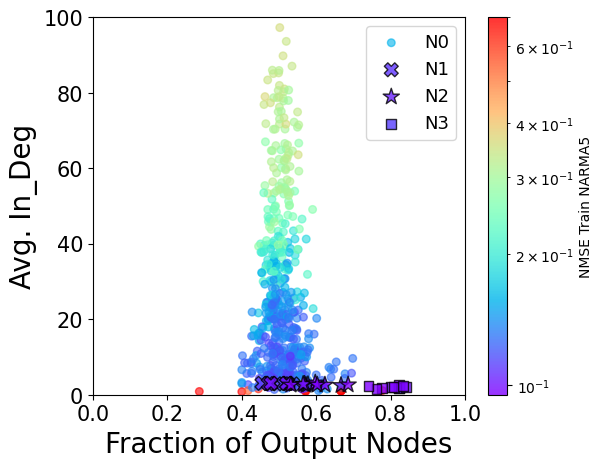

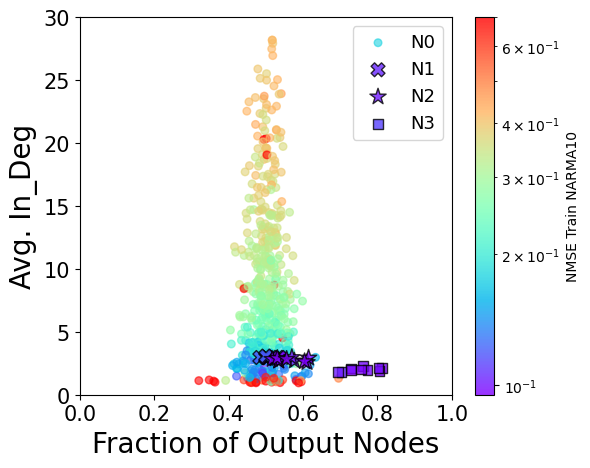

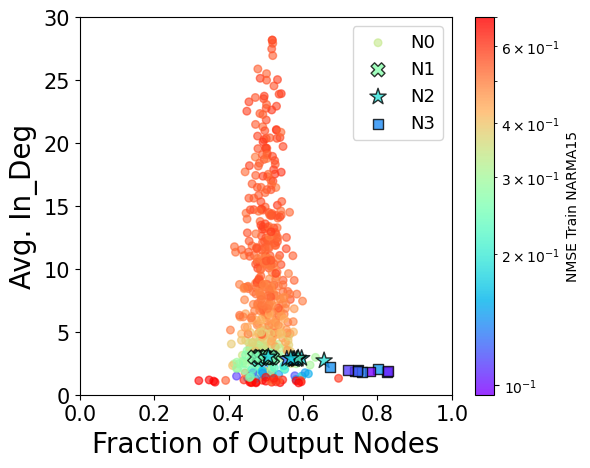

In [28]:
NodesVsProp_Plot(df, 'NARMA5', 'Fraction of Output Nodes', 'Avg. In_Deg', 'NMSE Train', [0.095, 0.7], Xlim=[0.,1], Ylim=[0.0,100])
NodesVsProp_Plot(df, 'NARMA10', 'Fraction of Output Nodes', 'Avg. In_Deg', 'NMSE Train', [0.095, 0.7], Xlim=[0.,1], Ylim=[0.,30])
NodesVsProp_Plot(df, 'NARMA15', 'Fraction of Output Nodes', 'Avg. In_Deg', 'NMSE Train', [0.095, 0.7], Xlim=[0.,1], Ylim=[0.,30])

In [29]:
NetMsrsV3_Names

array(['Nodes', 'Avg. CC', 'Avg. In_Deg', 'Avg. Out_Deg', 'Communities',
       'Density'], dtype='<U12')

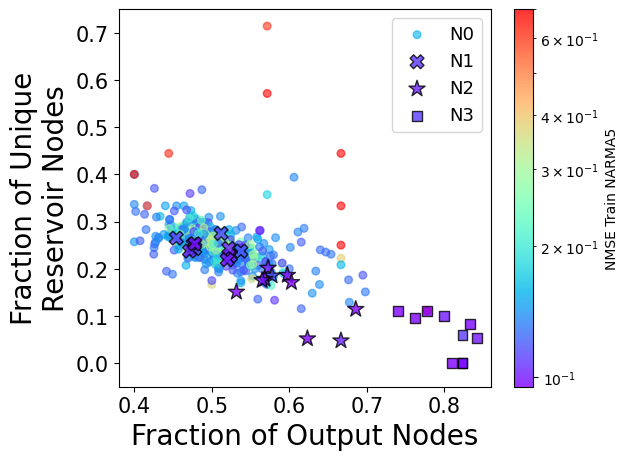

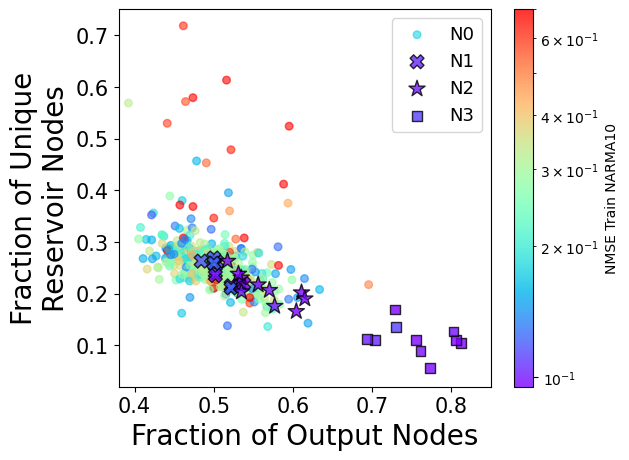

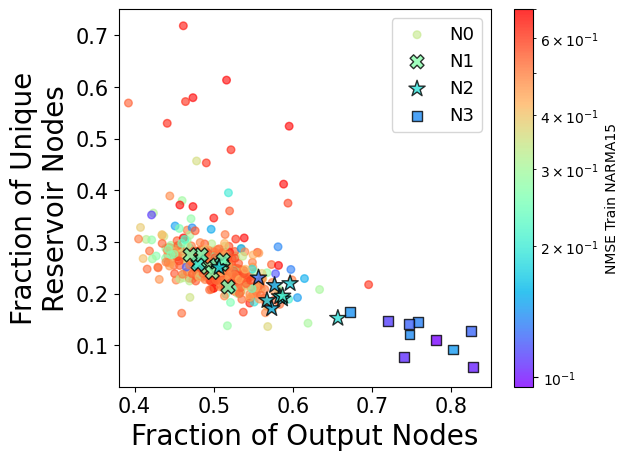

In [30]:
NodesVsProp_Plot(df, 'NARMA5', 'Fraction of Output Nodes', 'Fraction of Unique\nReservoir Nodes', 'NMSE Train', [0.095, 0.7], Xlim=[0.38,0.86], Ylim=[-0.05,0.75])
NodesVsProp_Plot(df, 'NARMA10', 'Fraction of Output Nodes', 'Fraction of Unique\nReservoir Nodes', 'NMSE Train', [0.095, 0.7], Xlim=[0.38,0.85], Ylim=[0.02,0.75])
NodesVsProp_Plot(df, 'NARMA15', 'Fraction of Output Nodes', 'Fraction of Unique\nReservoir Nodes', 'NMSE Train', [0.095, 0.7], Xlim=[0.38,0.85], Ylim=[0.02,0.75])

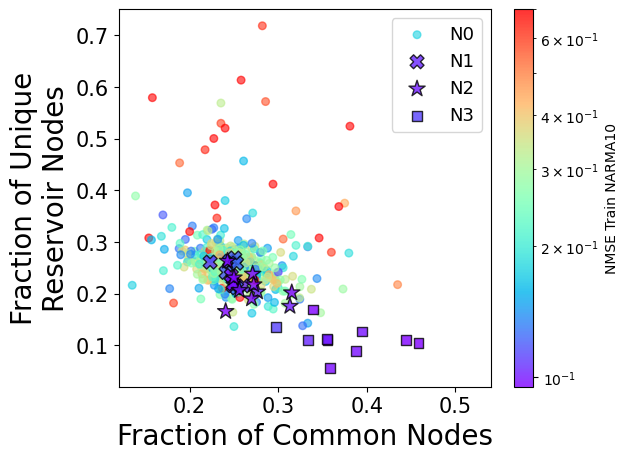

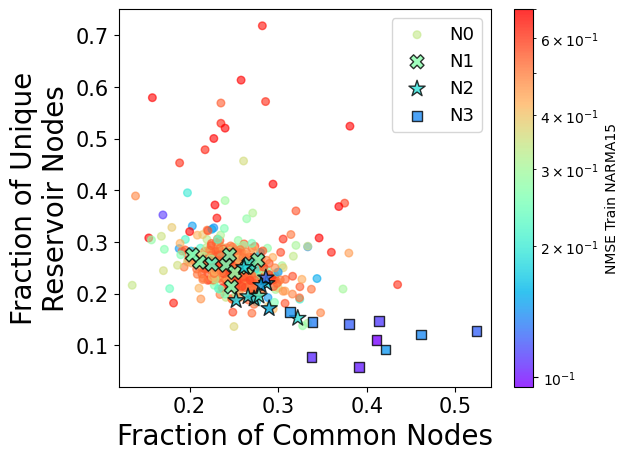

In [31]:
NodesVsProp_Plot(df, 'NARMA10', 'Fraction of Common Nodes', 'Fraction of Unique\nReservoir Nodes', 'NMSE Train', [0.095, 0.7], Xlim=[0.12,0.54], Ylim=[0.02,0.75])
NodesVsProp_Plot(df, 'NARMA15', 'Fraction of Common Nodes', 'Fraction of Unique\nReservoir Nodes', 'NMSE Train', [0.095, 0.7], Xlim=[0.12,0.54], Ylim=[0.02,0.75])